## Read in cuisine data

In [2]:
import pandas as pd
import numpy as np
import os


cuisines = pd.read_csv('cuisinedata\cuisine_data.csv', index_col = 'id')

# convert cooking time to minutes
cuisines['timeMins'] = cuisines.totalTimeInSeconds.apply(lambda x: x/60) 
cuisines.drop(['Unnamed: 0'], axis=1, inplace=True)

# convert ingredients from str to list
ingred = cuisines['ingredients'].values
ingredlist = []
for i in range(0, len(ingred)):
    ingredlist.append([x.strip() for x in ingred[i][1:-1].split(',')])
cuisines['ingredients']= ingredlist

# store ingredient count for each recipe
ingredcount = []
for i in range(0, len(ingredlist)):
    ingredcount.append(len(ingredlist[i]))
cuisines['ingred_count'] = ingredcount

# fill in missing courses
cuisines.course.fillna('Unknown', inplace=True)

In [5]:
# drop duplicates
cuisines = cuisines[cuisines.index.duplicated() == False]

## functions to generate a cuisine-specific dataframe for analysis

cuisineslist = ['american', 'italian', 'asian', 'mexican', 'southern', 'french', 'southwestern', 'barbecue', 'indian', 'chinese', 'cajun', 'mediterranean', 'greek', 'english', 'spanish', 'thai', 'german', 'moroccan', 'irish', 'japanese', 'cuban','hawaiian', 'swedish', 'hungarian', 'portuguese']

courselist = ['Main Dishes', 'Desserts', 'Side Dishes', 'Lunch and Snacks', 'Appetizers', 'Salads', 'Breakfast and Brunch', 'Breads', 'Soups', 'Beverages', 'Condiments and Sauces', 'Cocktails']

# function: generate a new dataframe filtered by cuisine
def cuisine_df_generator(cuis):
    cuisdf = cuisines[cuisines.cuisine.str.contains(cuis, case=False)].copy()
    return cuisdf

# function: inspect ratings
def cuisine_ratings(cuisdf):   
    print 'rating distribution: \n', cuisdf.rating.value_counts(), '\n\n', cuisdf.rating.describe(), '\n'

cuisine_ratings(cuisines)

# function: inspect cooking times
def cuisine_times(cuisdf): 
    print 'cooking time in mins: \n', cuisdf.timeMins.describe()
    
cuisine_times(cuisines)

rating distribution: 
4    4988
3    1517
5    1379
0     106
2      44
1       3
Name: rating, dtype: int64 

count    8037.000000
mean        3.918004
std         0.768092
min         0.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: rating, dtype: float64 

cooking time in mins: 
count    7733.000000
mean       64.672701
std       105.188347
min         1.000000
25%        25.000000
50%        40.000000
75%        65.000000
max      1970.000000
Name: timeMins, dtype: float64


In [6]:
# function: inspect cuisine distribution
def cuisine_cuisines(cuisdf):
    cuisine_counts = [] 
    for cuisine in cuisineslist:
        counter = 0
        for i in range(0, len(cuisdf.cuisine.value_counts())):
            if cuisine in cuisdf.cuisine.value_counts().index[i].lower():
                counter += cuisdf.cuisine.value_counts().values[i]
        cuisine_counts.append(counter)
    return dict(zip(cuisineslist, cuisine_counts))

cuisine_cuisines(cuisines)

# function: inspect count, avg time, and avg ingredients of courses
def cuisine_courses(cuisdf):
    course_counts = []    
    for course in courselist:
        print 'Count of ' + course + ': ' + str(len(cuisdf[cuisdf['course'].str.contains(course)]))
        course_counts.append(len(cuisdf[cuisdf['course'].str.contains(course)]))
        print 'Avg time in mins for ' + course + ': ' + str(cuisdf[cuisdf['course'].str.contains(course)].timeMins.mean())
        print 'Avg # of ingreds for ' + course + ': ' + str(cuisdf[cuisdf['course'].str.contains(course)].ingred_count.mean()) + '\n'
    return dict(zip(courselist, course_counts))

# function: inspect recipes based on number of ingredients
def cuisine_ingredients(cuisdf):
    print 'Ingredient distribution: \n', cuisdf.ingred_count.describe(), '\n'
    print 'Fewest ingredients: \n', cuisdf.sort('ingred_count')['ingred_count'].head(5), '\n'
    print 'Most ingredients: \n', cuisdf.sort('ingred_count')['ingred_count'].tail(5)

cuisine_ingredients(cuisines)

# function: inspect ingredient frequency (# of recipes with that ingredient/# of recipes overall)
def cuisine_unique_ingredients(cuisdf):
    cuis_ingredients = []
    for i in range(0, len(cuisdf.ingredients)):
        cuis_ingredients += list(cuisdf.ingredients[i])
    cuis_ingredients = pd.DataFrame(cuis_ingredients, columns=['instances'])
    cuis_unique_ingreds = pd.DataFrame(cuis_ingredients['instances'].value_counts(), columns=['instances'])
    cuis_unique_ingreds['frequency'] = cuis_unique_ingreds['instances']/len(cuisdf)
    return cuis_unique_ingreds

cuisine_unique_ingredients(cuisine_df_generator('thai'))

# function: calculate 2 uniqueness scores for each recipe WITHIN a cuisine
def cuisine_uniqueness(cuis):
    cuisdf = cuisine_df_generator(cuis)
    cuis_unique_ingreds = cuisine_unique_ingredients(cuisine_df_generator(cuis))
    uniq_score= []
    uniq_score2= []
    for i in range(0,len(cuisdf)):
        frequency_score = 0
        container = []
        for ingredient in cuisdf.iloc[i]['ingredients']:
            frequency_score += cuis_unique_ingreds.ix[ingredient]['frequency']
            container.append(cuis_unique_ingreds.ix[ingredient]['frequency'])
        uniq_score.append((frequency_score/cuisdf.iloc[i]['ingred_count'])*100)
        uniq_score2.append(np.product(container))
    cuisdf['uniq_score'] = uniq_score
    cuisdf['uniq_score2'] = uniq_score2
    return cuisdf


Ingredient distribution: 
count    8037.000000
mean       10.146199
std         4.350715
min         2.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        35.000000
Name: ingred_count, dtype: float64 

Fewest ingredients: 
id
Chocolate-Panini-Real-Simple-199065     2
German-Applesauce-1299137               2
Ratatouille-with-Eggs-Martha-Stewart    2
Edamame-Martha-Stewart-194809           2
Grilled-Barbeque-Chicken-1371395        2
Name: ingred_count, dtype: int64 

Most ingredients: 
id
The-Mexican-Bowl-1363648                                                       32
Scrambled-Eggs-With-Spice-studded-Rice-1369721                                 33
Chana-Masala-Waffles-with-Samosa-Potatoes-and-Cilantro-Mint-Chutney-1368231    34
Chicken-Biriyani-1369281                                                       35
Thai-Chicken-Tacos-_with-Bean-Sprout-Slaw-_-Peanut-Sauce_-1325442              35
Name: ingred_count, dtype: int64


C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:28: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [7]:
## dataframe for further analysis
italian = cuisine_uniqueness('italian')

# most unique and least unique Main Dishes
print 'Most unique :'
print italian[italian['course'].str.contains('Main Dishes')].sort_values(by='uniq_score')[['uniq_score', 'ingredients']].head(4)

Most unique :
                                                    uniq_score  \
id                                                               
Ravioli-with-Italian-Cheese-_-Herb-Cream-Sauce_...    0.712251   
Pasta-fagioli-297028                                  0.769231   
Spicy-Italian-Crescent-Ring-772394                    0.976801   
Goat-cheese-_-roasted-red-pepper-panini-297357        1.032764   

                                                                                          ingredients  
id                                                                                                     
Ravioli-with-Italian-Cheese-_-Herb-Cream-Sauce_...  [Italian cheese, cheese ravioli, sun-dried tom...  
Pasta-fagioli-297028                                [chunky pasta sauce, white kidney beans, froze...  
Spicy-Italian-Crescent-Ring-772394                  [Pillsbury™ Refrigerated Crescent Dinner Rolls...  
Goat-cheese-_-roasted-red-pepper-panini-297357      [bread, goat chee

In [8]:
# other dataframe inspections / sandbox:
len(cuisines)
cuisine_unique_ingredients(cuisines)
cuisines.columns
cuisine_cuisines(cuisines)

cuisines.sort('ingred_count').head(20)
cuisines.ix['Grilled-BBQ-Zucchini-1371766']

cuisines.timeMins.value_counts()
cuisines.dropna().sort('timeMins').tail(30)


C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count
id,,,,,,,,
Crock-Pot-Cuban-Pulled-Pork-1100915,Crock Pot Cuban Pulled Pork,4,44100.0,[Main Dishes],[Cuban],"[pork shoulder roast, lime, sour orange juice,...",735.0,12
Moroccan-Spiced-Grilled-Lamb-Wraps-1282601,Moroccan-Spiced Grilled Lamb Wraps,4,44700.0,[Main Dishes],[Barbecue],"[leg of lamb, salt, ground black pepper, lemon...",745.0,16
Awesome-Korean-Steak-Allrecipes,Awesome Korean Steak,5,45000.0,[Main Dishes],[Asian],"[fillets, soy sauce, white sugar, sesame seeds...",750.0,8
BBQ-Char-Siu-on-the-Grill-1206872,BBQ Char Siu on the Grill,4,45300.0,[Main Dishes],"[Barbecue, Asian]","[boneless pork shoulder, sugar, salt, chinese ...",755.0,15
Chicken-Portuguese-Style-_galinha-De-Vinha-D_ahlos_-Recipezaar,Chicken Portuguese Style (Galinha De Vinha D'a...,3,46800.0,[Main Dishes],[Portuguese],"[chicken thighs, white vinegar, salt, hot pepp...",780.0,9
Blazing-Brisket-Allrecipes,Blazing Brisket,4,46800.0,[Main Dishes],[Hungarian],"[beef brisket, bacon, brewed coffee, salt, but...",780.0,11
Red-Beans-Creole-1249126,Red Beans Creole,3,48300.0,[],[Cajun & Creole],"[red beans, water, chopped onion, sliced mushr...",805.0,10
Cuban-Black-Beans-I-Allrecipes,Cuban Black Beans I,4,49800.0,Unknown,[Cuban],"[black beans, onions, red bell pepper, green b...",830.0,13
Portuguese-Beef-_-Cacoila-Allrecipes,Portuguese Beef - Cacoila,4,50400.0,[Main Dishes],[Portuguese],"[beef stew meat, orange, white wine, hot peppe...",840.0,10


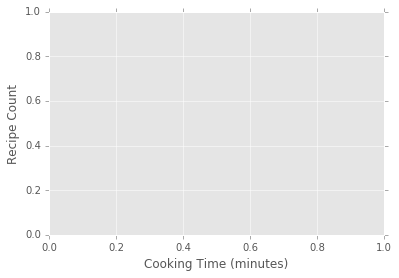

In [9]:
## visualization

import matplotlib.pyplot as plt
import matplotlib.axes as ax
%matplotlib inline

plt.style.available
plt.style.use('ggplot')
plt.xlabel('Cooking Time (minutes)')
plt.ylabel('Recipe Count')

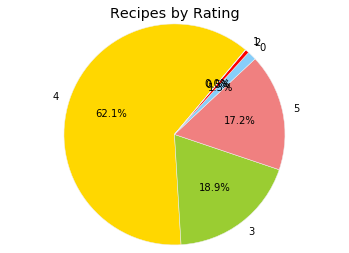

In [10]:
labels = ['4', '3', '5', '0', '2', '1']
plt.pie(cuisines.rating.value_counts(), labels=labels, autopct='%1.1f%%', colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red'], startangle=50, pctdistance=0.6)
plt.axis('equal')
plt.title('Recipes by Rating')
plt.show()

Count of Main Dishes: 3344
Avg time in mins for Main Dishes: 78.384319162
Avg # of ingreds for Main Dishes: 11.9392942584

Count of Desserts: 642
Avg time in mins for Desserts: 79.4603709949
Avg # of ingreds for Desserts: 7.3800623053

Count of Side Dishes: 609
Avg time in mins for Side Dishes: 48.828125
Avg # of ingreds for Side Dishes: 7.88177339901

Count of Lunch and Snacks: 437
Avg time in mins for Lunch and Snacks: 53.0648379052
Avg # of ingreds for Lunch and Snacks: 7.75743707094

Count of Appetizers: 543
Avg time in mins for Appetizers: 49.7607003891
Avg # of ingreds for Appetizers: 8.81399631676

Count of Salads: 480
Avg time in mins for Salads: 35.5553191489
Avg # of ingreds for Salads: 10.1104166667

Count of Breakfast and Brunch: 247
Avg time in mins for Breakfast and Brunch: 49.864628821
Avg # of ingreds for Breakfast and Brunch: 7.91902834008

Count of Breads: 291
Avg time in mins for Breads: 93.0729927007
Avg # of ingreds for Breads: 8.07216494845

Count of Soups: 534
Av

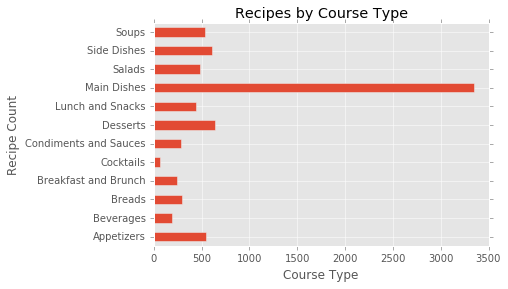

In [11]:
course_data = pd.Series(cuisine_courses(cuisines))
course_data.plot(kind='barh')
plt.xlabel('Course Type')
plt.ylabel('Recipe Count')
plt.title('Recipes by Course Type')
plt.show()

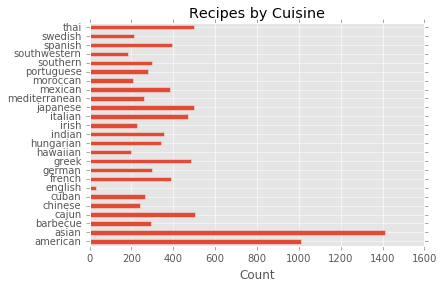

In [13]:
cuisine_cuisines(cuisines)
pd.Series(cuisine_cuisines(cuisines)).plot(kind='barh')
plt.xlabel('Count')
plt.title('Recipes by Cuisine')
plt.show()

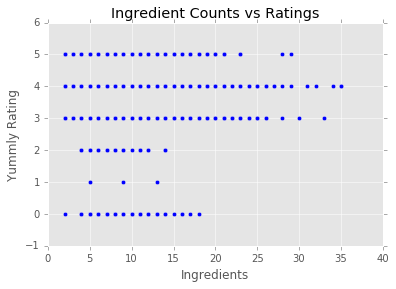

In [14]:
## relationships?

# ingredient/rating relationship?
import numpy as np
feature_cols = ['ingred_count']
X= cuisines[feature_cols]
y= cuisines.rating
plt.scatter(X, y)
plt.xlabel('Ingredients')
plt.ylabel('Yummly Rating')
plt.title('Ingredient Counts vs Ratings')
plt.show()

In [15]:
from sklearn.linear_model import LinearRegression
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

0.0029100600636868812

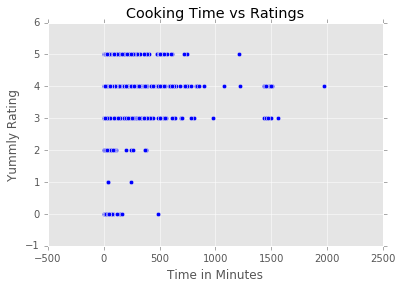

In [16]:
# cooking time/rating relationship?
feature_cols = ['timeMins']
X= cuisines.dropna()[feature_cols]
y= cuisines.dropna().rating
plt.scatter(X, y)
plt.xlabel('Time in Minutes')
plt.ylabel('Yummly Rating')
plt.title('Cooking Time vs Ratings')
plt.show()

In [17]:
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

2.3152846904128666e-06

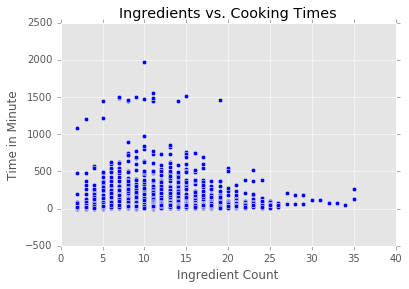

In [18]:
# ingredients/cooking time relationship?
feature_cols = ['ingred_count']
X= cuisines.dropna()[feature_cols]
y= cuisines.dropna()['timeMins']
plt.scatter(X, y)
plt.xlabel('Ingredient Count')
plt.ylabel('Time in Minute')
plt.title('Ingredients vs. Cooking Times')
plt.show()

In [19]:
linreg= LinearRegression()
linreg.fit(X, y)
linreg.intercept_
linreg.coef_
linreg.score(X, y)

0.006031425918799016

In [20]:
## cuisine predictor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split

In [21]:
# convert ingredients back into strings
ingredients_str = []
for i in cuisines.ingredients:
    ingredients_str.append(' '.join(i))
cuisines['ingred_str'] = ingredients_str

In [22]:
# convert cuisine types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines.cuisine)
cuisines['cuisine_label'] = le.transform(cuisines.cuisine)

In [115]:
# train/test/split bag of words with Multinomial NB
feature_cols = 'ingred_str'
X = cuisines[feature_cols]
y = cuisines.cuisine_label

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size = 0.2)

In [117]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [26]:
vect.vocabulary_

{u'stock': 1710,
 u'all': 22,
 u'sicilian': 1608,
 u'gai': 707,
 u'chinese': 341,
 u'unflavored': 1855,
 u'mackerel': 1038,
 u'ale': 20,
 u'yellow': 1950,
 u'four': 675,
 u'island': 885,
 u'asian': 64,
 u'parmesan': 1248,
 u'bucatini': 219,
 u'onions': 1207,
 u'porcini': 1363,
 u'chowchow': 362,
 u'preserves': 1386,
 u'canes': 262,
 u'beaters': 111,
 u'sparkling': 1667,
 u'sashimi': 1531,
 u'pancetta': 1237,
 u'granola': 763,
 u'dairy': 509,
 u'preserved': 1385,
 u'dressing': 563,
 u'nori': 1184,
 u'cress': 460,
 u'manis': 1054,
 u'turnips': 1841,
 u'premium': 1382,
 u'bruschetta': 217,
 u'deli': 525,
 u'rise': 1469,
 u'verbena': 1881,
 u'fat': 618,
 u'baton': 102,
 u'vera': 1880,
 u'romain': 1485,
 u'jack': 889,
 u'softened': 1649,
 u'veri': 1883,
 u'hemp': 837,
 u'ramen': 1430,
 u'fresca': 685,
 u'sichuan': 1607,
 u'caramels': 273,
 u'baking': 83,
 u'broiler': 211,
 u'wholemeal': 1928,
 u'large': 972,
 u'solid': 1650,
 u'prosciutto': 1393,
 u'poblano': 1350,
 u'moulard': 1146,
 u'cho

In [27]:
f=vect.inverse_transform(X_train_dtm)
f

[array([u'oil', u'onions', u'tomatoes', u'green', u'chile', u'pepper',
        u'salt', u'cumin', u'large', u'eggs', u'shredded', u'lettuce',
        u'cheese', u'chopped', u'cilantro', u'olive', u'spray', u'corn',
        u'tortillas'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'corn', u'egg', u'noodles', u'chicken',
        u'breasts', u'garlic', u'cabbage', u'carrots', u'oyster', u'sauce',
        u'soy', u'dark', u'sugar', u'sesame', u'water', u'white',
        u'beansprouts', u'scallions', u'baking', u'soda', u'starch'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'cilantro', u'garlic', u'sauce',
        u'soy', u'dark', u'sesame', u'water', u'swordfish', u'fillets',
        u'sea', u'ground', u'black', u'red', u'sweet', u'onion',
        u'pineapple', u'lime', u'crimini', u'mushrooms', u'crushed',
        u'ginger', u'juice', u'orange', u'lemon', u'unsweetened',
        u'coconut', u'milk', u'dijon', u'mustard', u'hoisin', u'reduced',
        u's

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
from sklearn import metrics
print metrics.accuracy_score(y_test, y_pred_class)

0.542910447761


In [29]:
# train/test/split with Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_logreg_pred_class = logreg.predict(X_test_dtm)
print metrics.accuracy_score(y_test, y_logreg_pred_class)

0.444029850746


In [30]:
len(cuisines.cuisine.value_counts())

206

# Advancements made to the above code

## ->Applying random Forest classifier

In [33]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train_dtm, y_train)
y_rf_pred_class = rf.predict(X_test_dtm)
print metrics.accuracy_score(y_test, y_rf_pred_class)

0.517412935323


## ->Applying K-Nearest Neighbours classifier

In [34]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = [1, 3, 5, 7, 9, 11, 13]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors= k, C = 100, gamma = 0.01)
    knn.fit(X_train_dtm,y_train)
    y_knn = knn.predict(X_test_dtm)
    print metrics.accuracy_score(y_test, y_knn)

C:\Users\dell\Anaconda2\envs\gl-env\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


0.421019900498
0.386815920398
0.416666666667
0.432213930348
0.427860696517
0.434701492537
0.437810945274


## ->Applying K-Fold Cross Validation

In [35]:
from sklearn.cross_validation import KFold, cross_val_score

In [36]:
X.shape

(8037L,)

### --> For Cuisines

In [37]:
yy = cuisines.cuisine_label
nb1 = MultinomialNB()
vectorizer = CountVectorizer()
xtr_dtm = vectorizer.fit_transform(X)
scores = cross_val_score(nb1, xtr_dtm, yy, cv = KFold(n = 8037, shuffle = True, n_folds = 100))
scores.mean()

0.55944753086419763

### ->For Recipes

In [118]:
# convert recitpe types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines.recipeName)
cuisines['recipe_label'] = le.transform(cuisines.recipeName)

# train/test/split bag of words with Multinomial NB
feature_cols = 'ingred_str'
X = cuisines[feature_cols]
y = cuisines.recipe_label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, test_size = 0.2)

vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

vect.vocabulary_

{u'stock': 1710,
 u'all': 22,
 u'sicilian': 1608,
 u'gai': 707,
 u'chinese': 341,
 u'unflavored': 1855,
 u'mackerel': 1038,
 u'ale': 20,
 u'yellow': 1950,
 u'four': 675,
 u'island': 885,
 u'asian': 64,
 u'parmesan': 1248,
 u'bucatini': 219,
 u'onions': 1207,
 u'porcini': 1363,
 u'chowchow': 362,
 u'preserves': 1386,
 u'canes': 262,
 u'beaters': 111,
 u'sparkling': 1667,
 u'sashimi': 1531,
 u'pancetta': 1237,
 u'granola': 763,
 u'dairy': 509,
 u'preserved': 1385,
 u'dressing': 563,
 u'nori': 1184,
 u'cress': 460,
 u'manis': 1054,
 u'turnips': 1841,
 u'premium': 1382,
 u'bruschetta': 217,
 u'deli': 525,
 u'rise': 1469,
 u'verbena': 1881,
 u'fat': 618,
 u'baton': 102,
 u'vera': 1880,
 u'romain': 1485,
 u'jack': 889,
 u'softened': 1649,
 u'veri': 1883,
 u'hemp': 837,
 u'ramen': 1430,
 u'fresca': 685,
 u'sichuan': 1607,
 u'caramels': 273,
 u'baking': 83,
 u'broiler': 211,
 u'wholemeal': 1928,
 u'large': 972,
 u'solid': 1650,
 u'prosciutto': 1393,
 u'poblano': 1350,
 u'moulard': 1146,
 u'cho

In [39]:
f=vect.inverse_transform(X_train_dtm)
f

[array([u'oil', u'onions', u'tomatoes', u'green', u'chile', u'pepper',
        u'salt', u'cumin', u'large', u'eggs', u'shredded', u'lettuce',
        u'cheese', u'chopped', u'cilantro', u'olive', u'spray', u'corn',
        u'tortillas'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'corn', u'egg', u'noodles', u'chicken',
        u'breasts', u'garlic', u'cabbage', u'carrots', u'oyster', u'sauce',
        u'soy', u'dark', u'sugar', u'sesame', u'water', u'white',
        u'beansprouts', u'scallions', u'baking', u'soda', u'starch'], 
       dtype='<U15'),
 array([u'oil', u'pepper', u'salt', u'cilantro', u'garlic', u'sauce',
        u'soy', u'dark', u'sesame', u'water', u'swordfish', u'fillets',
        u'sea', u'ground', u'black', u'red', u'sweet', u'onion',
        u'pineapple', u'lime', u'crimini', u'mushrooms', u'crushed',
        u'ginger', u'juice', u'orange', u'lemon', u'unsweetened',
        u'coconut', u'milk', u'dijon', u'mustard', u'hoisin', u'reduced',
        u's

In [119]:
yy = cuisines.recipe_label
nb1 = MultinomialNB()
vectorizer = CountVectorizer()
xtr_dtm = vectorizer.fit_transform(X)
scores = cross_val_score(nb1, xtr_dtm, yy, cv = KFold(n = 8037, shuffle = True, n_folds = 100))
scores.mean()

0.032104938271604939

In [33]:
cuisines.head()

,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count,ingred_str,cuisine_label
id,,,,,,,,,,
Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4,3600.0,Unknown,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b...",60.0,11,buttermilk cornbread sandwich bread salt black...,174
Peanut-butter-fudge-297693,Peanut Butter Fudge,4,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea...",135.0,5,Country Crock® Spread light corn syrup creamy ...,28
Buckeyes-298471,Buckeyes,4,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C...",110.0,4,Skippy® Super Chunk® Peanut Butter Country Cro...,28
Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper...",35.0,7,light mayonnaise lemon juice cayenne pepper sa...,28
Classic-macaroni-salad-304692,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m...",25.0,13,elbow macaroni hellmann' or best food real may...,28


## Find recipes that you can make given a set of supplies in the pantry

In [41]:
# find number of possible recipes
pantry = cuisine_unique_ingredients(cuisines).index[0:100]

In [44]:
def what_can_I_make():    
    cuisines['possible'] = False
    for i, row in cuisines.iterrows():
        possible = False
        if set(row.ingredients).issubset(set(pantry)):
            possible = True
            print row.recipeName
        cuisines.set_value(i, 'possible', possible)
    return cuisines.possible.value_counts()

In [45]:
what_can_I_make()

Hash Browns
Popovers
Simple Syrup
Caramelized Onions
Honey Limeade
Southern Fried Chicken
Limeade
Caramel Sauce
Roasted Quartered Chicken and Shallots
Carne Asada Marinade
Fresh Tomato Salsa
Paris, Part Deux
Simple Syrup
Glazed Lemon Pound Cake
Pan Gravy
Avocado Ice Cream
Roasted Garlic
Unagi Sauce
Grilled Potatoes
Cajun Potato Latkes
Chinese Steamed Eggs
Simple Syrup
Simple Syrup
Simple Syrup
Irish Tea Time and Scones
Yorkshire Pudding
Irish Scones
Yorkshire Pudding I
Lemon Posset
French Crepes
Garlic Confit
Profiteroles
French Petits Choux “Chouquettes”
Baked Pâte à Choux
Real French Crepes
Roux
German Pan Fried Potatoes (Bratkartoffeln)
German Pancakes II
Spritz Cookies
Cinnamon Stars
German-Russian-Dakota Knefla
German Cut-Out Cookies
Knefla Soup II
My Grandma’s Greek Dressing
Roasted Greek Potatoes with Feta Cheese and Lemon
Greek Scrambled Eggs
GORGEOUS GREEK CHICKEN AND POTATOES
Greek Potato Hash
Greek Salad IV
Easy Haupia
Chicken Paprikash
Paprikas Burgonya ( Paprika Potatoes

False    7923
True      114
Name: possible, dtype: int64

## Fire up Graphlab Create

In [1]:
import graphlab 

## Build a sentiment Classifier

### Define whats a positve/ negative sentiment

In [95]:
#ignore all 3 * rating
cuisine_new1 = cuisine_new[cuisine_new['rating'] != 3]

In [97]:
#positive sentiment = 4* , 5* rating
cuisine_new1['sentiment'] = cuisine_new1['rating'] >= 4

In [99]:
cuisine_new1.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


## Training sentiment Classifier

In [100]:
train_data,test_data = cuisine_new1.random_split(.8 , seed=0)

In [101]:
sentiment_model=graphlab.logistic_classifier.create(train_data,target='sentiment',features=['word_count'],validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 5672

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 4021

Number of coefficients    : 4022

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 3        | 0.000176  | 1.113607     | 0.976375          | 0.979695            |

| 2         | 6        | 5.000000  | 1.311748     | 0.982722          | 0.976795            |

| 3         | 7        | 5.000000  | 1.396816     | 0.320169          | 0.284989            |

| 4         | 9        | 1.000000  | 1.476865     | 0.986072          | 0.970993            |

| 5         | 10       | 1.000000  | 1.556922     | 0.988364          | 0.969543            |

| 6         | 11       | 1.000000  | 1.620967     | 0.991361          | 0.968818            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [102]:
sentiment_model.evaluate(test_data,metric='roc_curve')

{'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+---------------+------+----+
 | threshold | fpr |      tpr      |  p   | n  |
 +-----------+-----+---------------+------+----+
 |    0.0    | 1.0 |      1.0      | 1351 | 28 |
 |   1e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   2e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   3e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   4e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   5e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   6e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   7e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   8e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 |   9e-05   | 1.0 | 0.99925980755 | 1351 | 28 |
 +-----------+-----+---------------+------+----+
 [100001 rows x 5 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.}

In [104]:
graphlab.canvas.set_target('ipynb')
sentiment_model.show(view='Evaluation')

In [105]:
cuisine_new1['predicted_sentiment'] = sentiment_model.predict(cuisine_new1, output_type='probability')

## Sort the cuisines based on predicted sentiment and explore

In [106]:
cuisine_new1 = cuisine_new1.sort('predicted_sentiment', ascending= False)

In [107]:
cuisine_new1.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
280,Thai-Chicken-Tacos-_with-Bean-Sprout-Slaw-_ ...,Thai Chicken Tacos {withBean Sprout Slaw & Pe ...,4,16200.0,[Main Dishes]
151,The-Mexican-Bowl-1363648,The Mexican Bowl,4,4500.0,[]
133,Luau-Hawaiian-Fruit-Salad-1195315 ...,Luau Hawaiian Fruit Salad,4,1200.0,[Salads]
99,Easy-25-Minute-Spicy-Thai-Pumpkin-Noodles- ...,Easy 25 Minute Spicy ThaiPumpkin Noodles (with ...,4,1500.0,[Main Dishes]
447,Thai-Green-Curry-Meatballs-1272104 ...,Thai Green CurryMeatballs ...,4,3600.0,[Main Dishes]
149,Greek-Chicken-Stew-1297027 ...,Greek Chicken Stew,4,3000.0,[Main Dishes]
179,Greek-Chicken-Stew-1297027 ...,Greek Chicken Stew,4,3000.0,[Main Dishes]
161,Greek-Night_-1364391,Greek Night!,4,3000.0,[Main Dishes]
132,Greek-Night_-1364391,Greek Night!,4,3000.0,[Main Dishes]
107,Chana-Masala-Waffles-with-Samosa-Potatoes- ...,Chana Masala Waffles withSamosa Potatoes and ...,4,2700.0,[]


# Find recipes that you can make given a set of supplies in the pantry

In [108]:
# find number of possible recipes
pantry = cuisine_unique_ingredients(cuisines).index[0:100]

In [114]:
def what_can_I_make():    
    c=0
    for row in range(0,len(cuisine_new1['ingredients'])):
        if set(cuisine_new1['ingredients'][row]).issubset(set(pantry)):
            print cuisine_new1['recipeName'][row]
            c=c+1
    print "Possible=",c
    print "Not Possible",(8037-c)

what_can_I_make()

Roasted Greek Potatoes with Feta Cheese and Lemon
Greek Potato Hash
Greek Potato Hash
German Cut-Out Cookies
Lemon Posset
Eel Sauce
Irish Tea Time and Scones
Irish Tea Time and Scones
Caramel Sauce
Caramel Sauce
Cajun Potato Latkes
Irish Scones
Irish Scones
Swedish Scones
GORGEOUS GREEK CHICKEN AND POTATOES
Greek Scrambled Eggs
German Pan Fried Potatoes (Bratkartoffeln)
Brown Swedish Cookies
Preserved Lemons
Unagi Sauce
Unagi Sauce
Portuguese Coriander Soup (Sopa De Coentro)
Roasted Carrots with Feta and Parsley
Swedish Pancakes
Italian Roasted Peppers
IRISH POTATO SOUP
Honey Limeade
Norwegian Lefse
Roasted Red Peppers with Garlic and Olive Oil
Yorkshire Pudding
Hash Browns
Hungarian Potato Pancakes
Caramelized Onions
Carne Asada Marinade
Easy Haupia
Swedish Pancakes
Molho De Piri-Piri (Portuguese Peri-Peri Marinade Sauce)
Irish Champ
Avocado Ice Cream
Spritz Cookies
Spanish Fried Eggs
Popovers
Fried Chicken
Chicken Paprikash
Glazed Lemon Pound Cake
Swedish Raspberry Kiss Cookies
South

In [6]:
import graphlab
cuisine_new = graphlab.SFrame.read_csv('cuisinedata\cuisine_data.csv')

This non-commercial license of GraphLab Create for academic use is assigned to ishankagarwal62@gmail.com and will expire on September 12, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\dell\AppData\Local\Temp\graphlab_server_1511601620.log.0


Finished parsing file C:\Users\dell\cuisinedata\cuisine_data.csv

Parsing completed. Parsed 100 lines in 0.603575 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,str,str,long,float,list,list,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\dell\cuisinedata\cuisine_data.csv

Parsing completed. Parsed 8664 lines in 0.371008 secs.

In [3]:
# convert cuisine types to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_new['cuisine'])
cuisine_new['cuisine_label'] = le.transform(cuisine_new['cuisine'])

In [83]:
cuisines.shape

(8037, 12)

## Apply Clustering model to predict similar dishes

In [84]:
pizza = cuisine_new[cuisine_new['recipeName']== 'Grilled Buffalo Chicken Pizza']

In [85]:
pizza.head()

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+
|          ingredients          | cuisine_label |
+-------------------------------+---------------+
| [prebaked pizza crusts, ra... |       0       |
+-------------------------------+---------------+
[1 rows x 9 columns]

In [86]:
pizza['ingredients']

dtype: list
Rows: ?
[['prebaked pizza crusts', 'ragu organic pasta sauc', 'buffalo chicken strip style', 'celery', 'shredded mozzarella cheese', 'blue cheese'], ... ]

In [87]:
pizza['word_count']=graphlab.text_analytics.count_words(pizza['ingredients'])
pizza

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int
	word_count	dict

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+-------------------------------+
|          ingredients          | cuisine_label |           word_count          |
+-------------------------------+---------------+-------------------------------+
| [prebaked pizza crusts, ra... |       0       | {'blue': 1L, 'cheese': 2L,... |
+-------------------------------+---------------+-------------------------------+
[1 rows x 10 columns]

In [88]:
pizza_word_count_table = pizza[['word_count']].stack('word_count', new_column_name=['word','count'])

In [89]:
pizza_word_count_table.head()

word,count
blue,1
cheese,2
mozzarella,1
shredded,1
celery,1
style,1
prebaked,1
pizza,1
sauc,1
ragu,1


In [90]:
pizza_word_count_table.sort('count', ascending= False)

word,count
cheese,2
blue,1
mozzarella,1
shredded,1
celery,1
style,1
prebaked,1
pizza,1
sauc,1
ragu,1


## Examine tf-idf for the corpus

In [4]:
#Converting list into string
ingredients_str = []
for i in range(0,len(cuisine_new['ingredients'])):
    ingredients_str.append(str(cuisine_new['ingredients'][i]))
cuisine_new['ingred_str'] = ingredients_str

In [92]:
cuisine_new['word_count']= graphlab.text_analytics.count_words(cuisine_new['ingred_str'])

In [93]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


In [254]:
tfidf=graphlab.text_analytics.tf_idf(cuisine_new['word_count'])
tfidf

dtype: dict
Rows: 8664
[{"stock']": 6.022409350957403, "soup',": 5.15490878325268, "'eggs',": 2.4974503682665308, "pepper',": 1.1334934010533375, "'salt',": 1.0197422265103246, 'of': 4.3219996603175765, "'black": 2.345506087890183, "sage',": 5.848055963812626, "'chicken": 2.3873326028364437, "'butter',": 2.599233062576473, "bread',": 4.154276902944774, "'cream": 4.1993973382252445, "'sandwich": 6.5019824312192895, "cornbread',": 8.37378460812088, "['buttermilk": 7.680637427560936, "'rubbed": 7.457493876246726, "'celery',": 3.5454708708185803, 'chicken': 2.2623172686182027, "'onions',": 1.7280436548419473}, {"sugar',": 1.944065130081744, "['country": 6.294343066441045, "butter',": 2.600787064443207, "'confectioners": 4.30475785388307, "'vanilla": 3.428577119347081, 'peanut': 4.804251911639511, 'corn': 4.672482634008388, "spread',": 5.808835250659344, "syrup',": 4.471811938546237, 'crock\xc2\xae': 6.358881587578616, "'light": 3.3207285981406733, "extract']": 5.195730777772936, "'creamy":

In [255]:
cuisine_new['tfidf'] = tfidf

In [256]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


## Examine tf-idf for pizza

In [257]:
pizza = cuisine_new[cuisine_new['recipeName']== 'Grilled Buffalo Chicken Pizza']

In [258]:
pizza.head()

Columns:
	X1	int
	id	str
	recipeName	str
	rating	int
	totalTimeInSeconds	float
	course	list
	cuisine	list
	ingredients	list
	cuisine_label	int
	ingred_str	str
	word_count	dict
	tfidf	dict
	ingred_count	int

Rows: 1

Data:
+-----+-------------------------------+-------------------------------+--------+
|  X1 |               id              |           recipeName          | rating |
+-----+-------------------------------+-------------------------------+--------+
| 131 | Grilled-buffalo-chicken-pi... | Grilled Buffalo Chicken Pizza |   4    |
+-----+-------------------------------+-------------------------------+--------+
+--------------------+---------------+------------+
| totalTimeInSeconds |     course    |  cuisine   |
+--------------------+---------------+------------+
|       1500.0       | [Main Dishes] | [American] |
+--------------------+---------------+------------+
+-------------------------------+---------------+-------------------------------+
|          ingredients          | cuisine_label |           ingred_str          |
+-------------------------------+---------------+-------------------------------+
| [prebaked pizza crusts, ra... |       0       | ['prebaked pizza crusts', ... |
+-------------------------------+---------------+-------------------------------+
+-------------------------------+-------------------------------+--------------+
|           word_count          |             tfidf             | ingred_count |
+-------------------------------+-------------------------------+--------------+
| {"['prebaked": 1L, "'ragu"... | {"['prebaked": 8.373784608... |      6       |
+-------------------------------+-------------------------------+--------------+
[1 rows x 13 columns]

In [259]:
pizza[['tfidf']].stack('tfidf',new_column_name=['word','tfidf']).sort('tfidf',ascending=False)

word,tfidf
"style',",9.06693178868
'buffalo,8.37378460812
['prebaked,8.37378460812
organic,7.68063742756
strip,7.68063742756
"crusts',",6.86970721134
'blue,6.66903651588
'ragu,6.42787445907
pizza,6.23371844462
"sauc',",6.17656003078


## Build a nearest neighbour model for finding similar dishes

In [260]:
knn_model=graphlab.nearest_neighbors.create(cuisine_new,features=['tfidf'],label='recipeName')

Starting brute force nearest neighbors model training.

## Applying nearest neighbour models for retrievAL

### Which dish is closest to Pizza ?

In [261]:
knn_model.query(pizza , k=10)

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.011542    | 108.01ms     |

| Done         |         | 100         | 136.011ms    |

+--------------+---------+-------------+--------------+

query_label,reference_label,distance,rank
0,Grilled Buffalo ChickenPizza ...,0.0,1
0,Pizza Pinwheels,0.7,2
0,Weeknight Skillet Lasagna,0.730769230769,3
0,Classic Hawaiian Pizza,0.791666666667,4
0,Italian Alfredo BroccoliStrata ...,0.8,5
0,Chicken Parmesan Alfredo,0.8,6
0,Lasagna With A Twist,0.8,7
0,Easy Beef Lasagna(featuring Ragu 2 Lb. 13 ...,0.806451612903,8
0,Italian Baked Pasta,0.826086956522,9
0,Chicken Parmigiana,0.827586206897,10


# train_data,test_data = cuisine_new.random_split(.8,seed=0)

In [210]:
lin_reg_model=graphlab.logistic_classifier.create(train_data,target='cuisine_label',features=['ingredients'],validation_set=test_data)

Logistic regression:

--------------------------------------------------------

Number of examples          : 6972

Number of classes           : 190

Number of feature columns   : 1

Number of unpacked features : 1

Number of coefficients    : 698922

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 1         | 4        | 0.000717  | 4.021771     | 0.628514          | 0.475768            |

| 2         | 6        | 1.000000  | 45.915581    | 0.752295          | 0.530142            |

| 3         | 7        | 1.000000  | 87.209276    | 0.797619          | 0.538416            |

| 4         | 8        | 1.000000  | 130.085678   | 0.837780          | 0.539007            |

| 5         | 9        | 1.000000  | 168.758682   | 0.868474          | 0.528960            |

| 6         | 10       | 1.000000  | 209.646686   | 0.886976          | 0.528369            |

| 7         | 11       | 1.000000  | 258.828394   | 0.904045          | 0.526005            |

| 8         | 12       | 1.000000  | 296.136890   | 0.914659          | 0.525414            |

| 9         | 13       | 1.000000  | 338.245527   | 0.926420          | 0.521868            |

| 10        | 14       | 1.000000  | 377.237986   | 0.939042          | 0.512411            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

TERMINATED: Iteration limit reached.

This model may not be optimal. To improve it, consider increasing `max_iterations`.

In [206]:
print lin_reg_model.evaluate(test_data)

{'max_error': 268.78635073066107, 'rmse': 61.143813460548316}


In [209]:
print lin_reg_model.predict(pizza)

[-1.0598002411011507]


In [227]:
cuisines.head()

,recipeName,rating,totalTimeInSeconds,course,cuisine,ingredients,timeMins,ingred_count,ingred_str,cuisine_label,possible,recipe_label
id,,,,,,,,,,,,
Southern-Cornbread-Dressing-1357820,Southern Cornbread Dressing,4,3600.0,Unknown,[Southern & Soul Food],"[buttermilk cornbread, sandwich bread, salt, b...",60.0,11,buttermilk cornbread sandwich bread salt black...,174,False,5457
Peanut-butter-fudge-297693,Peanut Butter Fudge,4,8100.0,[Desserts],[American],"[Country Crock® Spread, light corn syrup, crea...",135.0,5,Country Crock® Spread light corn syrup creamy ...,28,False,4485
Buckeyes-298471,Buckeyes,4,6600.0,[Desserts],[American],"[Skippy® Super Chunk® Peanut Butter, Country C...",110.0,4,Skippy® Super Chunk® Peanut Butter Country Cro...,28,False,572
Disappearing-buffalo-chicken-dip-297712,Disappearing Buffalo Chicken Dip,4,2100.0,[Appetizers],[American],"[light mayonnaise, lemon juice, cayenne pepper...",35.0,7,light mayonnaise lemon juice cayenne pepper sa...,28,False,1778
Classic-macaroni-salad-304692,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]",[American],"[elbow macaroni, hellmann' or best food real m...",25.0,13,elbow macaroni hellmann' or best food real may...,28,False,1299


In [5]:
# store ingredient count for each recipe
ingredcount = []
for i in range(0, len(cuisine_new['ingredients'])):
    ingredcount.append(len(cuisine_new['ingredients'][i]))
cuisine_new['ingred_count'] = ingredcount

In [257]:
cuisines.show(view='BoxWhisker Plot' , x='ingred_count' , y='totalTimeInSeconds')

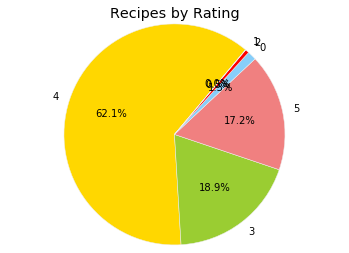

In [249]:
labels = ['4', '3', '5', '0', '2', '1']
plt.pie(cuisines.rating.value_counts(), labels=labels, autopct='%1.1f%%', colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red'], startangle=50, pctdistance=0.6)
plt.axis('equal')
plt.title('Recipes by Rating')
plt.show()

In [3]:
import graphlab
cuisines = graphlab.SFrame.read_csv('cuisinedata\cuisinedata.csv')

Finished parsing file C:\Users\dell\cuisinedata\cuisinedata.csv

Parsing completed. Parsed 100 lines in 0.76154 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,long,long,list,list,list,long,long,long,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\dell\cuisinedata\cuisinedata.csv

Parsing completed. Parsed 8338 lines in 0.531531 secs.

In [5]:
graphlab.canvas.set_target('ipynb')
cuisines.show(view="Bar Chart", x="cuisine_label", y="recipe_label")

In [6]:
cuisines.show(view="Scatter Plot", x="rating", y="ingred_count")

In [7]:
cuisines.show(view="Scatter Plot", x="rating", y="totalTimeInSeconds")

In [94]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


# PART TWO of Project

In [10]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


Armed with these SArray functions we can use the closed form solution found from lecture to compute the slope and intercept for a simple linear regression on observations stored as SArrays: input_feature, output.

### Split the data into train and test data

In [15]:
train_data,test_data = cuisine_new.random_split(.8,seed=0)

## Build a generic simple linear regression function

In [8]:
def simple_linear_regression(input_feature, output):
    Xi = input_feature
    Yi = output
    N = len(Xi)
    # compute the mean of  input_feature and output
    Ymean = Yi.mean()
    Xmean = Xi.mean()
    
    # compute the product of the output and the input_feature and its mean
    SumYiXi = (Yi * Xi).sum()
    YiXiByN = (Yi.sum() * Xi.sum()) / N
    
    # compute the squared value of the input_feature and its mean
    XiSq = (Xi * Xi).sum()
    XiXiByN = (Xi.sum() * Xi.sum()) / N
    
    # use the formula for the slope
    slope = (SumYiXi - YiXiByN) / (XiSq - XiXiByN)
    
    # use the formula for the intercept
    intercept = Ymean - (slope * Xmean)
    return (intercept, slope)

We can test that our function works by passing it something where we know the answer. In particular we can generate a feature and then put the output exactly on a line: output = 1 + 1*input_feature then we know both our slope and intercept should be 1

In [9]:
test_feature = graphlab.SArray(range(5))
test_output = graphlab.SArray(1 + 1*test_feature)
(test_intercept, test_slope) =  simple_linear_regression(test_feature, test_output)
print "Intercept: " + str(test_intercept)
print "Slope: " + str(test_slope)

Intercept: 1.0
Slope: 1


In [7]:
# convert ingredients to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_new['ingredients'])
cuisine_new['ingred_label'] = le.transform(cuisine_new['ingredients'])

In [11]:
# convert Cuisines to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_new['cuisine'])
cuisine_new['cuisine_label'] = le.transform(cuisine_new['cuisine'])

In [12]:
cuisine_new.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


Now that we know it works let's build a regression model for predicting cuisines based on ingredients. Rembember that we train on train_data!

In [20]:
ingred_intercept, ingred_slope = simple_linear_regression(train_data['ingred_label'], train_data['cuisine_label'])

print "Intercept: " + str(ingred_intercept)
print "Slope: " + str(ingred_slope)

Intercept: 110.091652324
Slope: 0


### Predicting Values

Now that we have the model parameters: intercept & slope we can make predictions. Using SArrays it's easy to multiply an SArray by a constant and add a constant value. Following function to return the predicted output given the input_feature, slope and intercept:

In [22]:
def get_regression_predictions(input_feature, intercept, slope):
    # calculate the predicted values:
    predicted_values = intercept + (slope * input_feature)
    return predicted_values

Now that we can calculate a prediction given the slope and intercept let's make a prediction. Use (or alter) the following to find out the estimated cuisnes for ingredients with label 127 according to the model we estiamted above.

In [31]:
cuisine_new['ingredients']['ingred_label' == 127]

['buttermilk cornbread',
 'sandwich bread',
 'salt',
 'black pepper',
 'rubbed sage',
 'eggs',
 'onions',
 'celery',
 'butter',
 'cream of chicken soup',
 'chicken stock']

In [24]:
my_ingred = 127
estimated_cuisine = get_regression_predictions(my_ingred, ingred_intercept, ingred_slope)
print "The estimated cuisine for ingredients list %d is %.2f" % (my_ingred, estimated_cuisine)

The estimated cuisine for ingredients list 127 is 110.09


In [32]:
print cuisine_new['cuisine']['cuisine_label' == 110] 

['Southern & Soul Food']


In [33]:
print cuisine_new['recipeName']['cuisine_label' == 110] 

Southern Cornbread Dressing


## Residual Sum of Squares

Now that we have a model and can make predictions let's evaluate our model using Residual Sum of Squares (RSS). Recall that RSS is the sum of the squares of the residuals and the residuals is just a fancy word for the difference between the predicted output and the true output.
Function to compute the RSS of a simple linear regression model given the input_feature, output, intercept and slope:

In [27]:
def get_residual_sum_of_squares(input_feature, output, intercept, slope):
    # First get the predictions
    predicted_values = intercept + (slope * input_feature)
    # then compute the residuals (since we are squaring it doesn't matter which order you subtract)
    residuals = output - predicted_values
    # square the residuals and add them up
    RSS = (residuals * residuals).sum()
    return(RSS)

Let's test our get_residual_sum_of_squares function by applying it to the test model where the data lie exactly on a line. Since they lie exactly on a line the residual sum of squares should be zero!

In [28]:
print get_residual_sum_of_squares(test_feature, test_output, test_intercept, test_slope) # should be 0.0

4.93038065763e-32


Now use your function to calculate the RSS on training data from the model calculated above.
According to this function and the slope and intercept from the model What is the RSS for the simple linear regression using ingredients to predict cuisines on TRAINING data?

In [30]:
rss_cuisines_on_ingred = get_residual_sum_of_squares(train_data['ingred_label'], train_data['cuisine_label'], ingred_intercept, ingred_slope)
print 'The RSS of predicting Cuisines based on Ingredients is : ' + str(rss_cuisines_on_ingred)

The RSS of predicting Cuisines based on Ingredients is : 22762402.4342


In [48]:
cuisine_new

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600.0,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100.0,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600.0,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100.0,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500.0,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600.0,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200.0,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700.0,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800.0,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600.0,[Desserts]


In [59]:
(example_features, example_output) = get_numpy_data(cuisine_new, ['ingred_label'], 'cuisine_label') # the [] around 'ingred_label' makes it a list
print example_features[0,:] # this accesses the first row of the data the ':' indicates 'all columns'
print example_output[0] # and the corresponding output

[   1 1442]
166


In [60]:
my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1443.0


np.dot() also works when dealing with a matrix and a vector. Recall that the predictions from all the observations is just the RIGHT (as in weights on the right) dot product between the features matrix and the weights vector. With this in mind finish the following predict_output function to compute the predictions for an entire matrix of features given the matrix and the weights: 

In [61]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

In [63]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1443.0
print test_predictions[1] # should be 67.0

1443.0
67.0


## Assessing Fit (Polynomial regression)

Will compare different regression models in order to assess which model fits best. We will be using polynomial regression as a means to examine this topic. In particular you will:
- Write a function to take an SArray and a degree and return an SFrame where each column is the SArray to a polynomial value up to the total degree e.g. degree = 3 then column 1 is the SArray column 2 is the SArray squared and column 3 is the SArray cubed
- Use matplotlib to visualize polynomial regressions
- Use matplotlib to visualize the same polynomial degree on different subsets of the data
- Use a validation set to select a polynomial degree
- Assess the final fit using test data

Next we're going to write a polynomial function that takes an SArray and a maximal degree and returns an SFrame with columns containing the SArray to all the powers up to the maximal degree.
The easiest way to apply a power to an SArray is to use the .apply() and lambda x: functions. For example to take the example array and compute the third power we can do as follows: (note running this cell the first time may take longer than expected since it loads graphlab)

In [90]:
tmp = graphlab.SArray([1., 2., 3.])
tmp_cubed = tmp.apply(lambda x: x**3)
print tmp
print tmp_cubed

[1.0, 2.0, 3.0]
[1.0, 8.0, 27.0]


We can create an empty SFrame using graphlab.SFrame() and then add any columns to it with ex_sframe['column_name'] = value. For example we create an empty SFrame and make the column 'power_1' to be the first power of tmp (i.e. tmp itself).

In [91]:
ex_sframe = graphlab.SFrame()
ex_sframe['power_1'] = tmp
print ex_sframe

+---------+
| power_1 |
+---------+
|   1.0   |
|   2.0   |
|   3.0   |
+---------+
[3 rows x 1 columns]



## Polynomial_sframe function

Create an SFrame consisting of the powers of an SArray up to a specific degree:

In [92]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = graphlab.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = feature ** power
    return poly_sframe

Test function consider the smaller tmp variable and what we would expect the outcome of the following call:

In [93]:
print polynomial_sframe(tmp, 3)

+---------+---------+---------+
| power_1 | power_2 | power_3 |
+---------+---------+---------+
|   1.0   |   1.0   |   1.0   |
|   2.0   |   4.0   |   8.0   |
|   3.0   |   9.0   |   27.0  |
+---------+---------+---------+
[3 rows x 3 columns]



### Visualizing polynomial regression

We will use the ingred_label variable. For plotting purposes (connecting the dots), we need to sort by the values of ingred_label. For Cuisines with identical Ingredients, we break the tie by their Recipes names.

In [94]:
cuisine_newer = cuisine_new.sort(['ingred_label', 'cuisine_label'])

Let's start with a degree 1 polynomial using 'Ingredients' (i.e. a line) to predict 'Cuisines' and plot what it looks like.

In [95]:
poly1_data = polynomial_sframe(cuisine_newer['ingred_label'], 1)
poly1_data['cuisine_label'] = cuisine_newer['cuisine_label'] # add cuisnes to the data since it's the target

In [96]:
print poly1_data

+---------+---------------+
| power_1 | cuisine_label |
+---------+---------------+
|    0    |       0       |
|    1    |       40      |
|    2    |       84      |
|    3    |       66      |
|    4    |      154      |
|    5    |      132      |
|    6    |       91      |
|    7    |      132      |
|    8    |      139      |
|    9    |       8       |
+---------+---------------+
[8664 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [97]:
model1 = graphlab.linear_regression.create(poly1_data, target = 'cuisine_label', features = ['power_1'], validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 8664

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 1.184238     | 112.038021         | 57.286671     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [98]:
#let's take a look at the weights before we plot
model1.get("coefficients")

name,index,value,stderr
(intercept),None,108.497604303,1.23198879579
power_1,None,0.000449291399898,0.000270570185454


In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

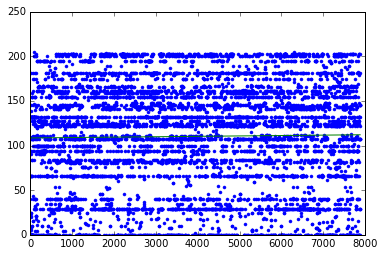

In [101]:
plt.plot(poly1_data['power_1'],poly1_data['cuisine_label'],'.',
        poly1_data['power_1'], model1.predict(poly1_data),'-')

Let's unpack that plt.plot() command. The first pair of SArrays we passed are the 1st power of Ingredients and the actual Cuisines we then ask it to print these as dots '.'. The next pair we pass is the 1st power of Ingredients and the predicted values from the linear model. We ask these to be plotted as a line '-'.
We can see, not surprisingly, that the predicted values all fall on a line, specifically the one with slope 280 and intercept -43579. What if we wanted to plot a second degree polynomial?

In [102]:
poly2_data = polynomial_sframe(cuisine_newer['ingred_label'], 2)
my_features = poly2_data.column_names() # get the name of the features
poly2_data['cuisine_label'] = cuisine_newer['cuisine_label'] # add price to the data since it's the target
model2 = graphlab.linear_regression.create(poly2_data, target = 'cuisine_label', features = my_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 8664

Number of features          : 2

Number of unpacked features : 2

Number of coefficients    : 3

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.008001     | 113.947053         | 57.196067     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [103]:
model2.get("coefficients")

name,index,value,stderr
(intercept),None,101.282732484,1.84640985701
power_1,None,0.00594164369804,0.00108247147699
power_2,None,-6.96898877319e-07,1.33002755602e-07


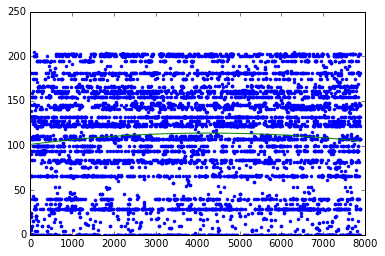

In [105]:
plt.plot(poly2_data['power_1'],poly2_data['cuisine_label'],'.',
        poly2_data['power_1'], model2.predict(poly2_data),'-')

The resulting model looks like half a parabola

In [106]:
poly3_data = polynomial_sframe(cuisine_newer['ingred_label'], 3)
poly3_features = poly3_data.column_names() # get the name of the features
poly3_data['cuisine_label'] = cuisine_newer['cuisine_label'] # add price to the data since it's the target
model3 = graphlab.linear_regression.create(poly3_data, target = 'cuisine_label', features = poly3_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 8664

Number of features          : 3

Number of unpacked features : 3

Number of coefficients    : 4

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.020000     | 114.272573         | 57.174053     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [107]:
model3.get("coefficients")

name,index,value,stderr
(intercept),None,97.1029488148,2.45861013121
power_1,None,0.0123033200894,0.00269796190451
power_2,None,-2.71535722918e-06,7.95256779398e-07
power_3,None,1.7081478492e-10,6.63478016512e-11


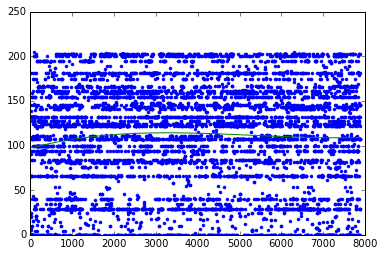

In [109]:
plt.plot(poly3_data['power_1'], poly3_data['cuisine_label'],'.',
        poly3_data['power_1'], model3.predict(poly3_data),'-')

In [110]:
poly15_data = polynomial_sframe(cuisine_newer['ingred_label'], 15)
poly15_features = poly15_data.column_names() # get the name of the features
poly15_data['cuisine_label'] = cuisine_newer['cuisine_label'] # add price to the data since it's the target
model15 = graphlab.linear_regression.create(poly15_data, target = 'cuisine_label', features = poly15_features, validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 8664

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.056006     | 114.667819         | 57.115926     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

In [111]:
model15.get("coefficients")

name,index,value,stderr
(intercept),None,99.1315542353,6.9584542406
power_1,None,0.00192697046494,0.0643874495546
power_2,None,7.84062079083e-06,0.000166389081186
power_3,None,-2.91648009831e-09,nan
power_4,None,4.38350574057e-14,nan
power_5,None,5.00232487571e-17,nan
power_6,None,4.20298293279e-21,nan
power_7,None,-2.25264799444e-25,nan
power_8,None,-1.0089937607e-28,nan
power_9,None,-1.35334997291e-32,1.20239566629e-27


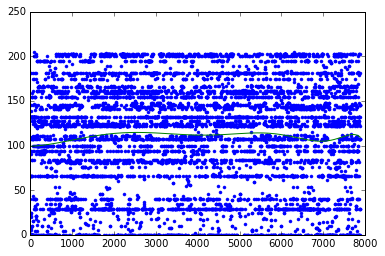

In [112]:
plt.plot(poly15_data['power_1'],poly15_data['cuisine_label'],'.',
        poly15_data['power_1'], model15.predict(poly15_data),'-')

What do you think of the 15th degree polynomial? Do you think this is appropriate? If we were to change the data do you think you'd get pretty much the same curve? Let's take a look.

### Changing the data and re-learning

We're going to split the data into four subsets of roughly equal size. Then you will estimate a 15th degree polynomial model on all four subsets of the data. Print the coefficients (you should use .print_rows(num_rows = 16) to view all of them) and plot the resulting fit (as we did above).
To split the sales data into four subsets, we perform the following steps:
- First split sales into 2 subsets with .random_split(0.5, seed=0).
- Next split the resulting subsets into 2 more subsets each. Use .random_split(0.5, seed=0).

We set seed=0 in these steps so that different users get consistent results. You should end up with 4 subsets (set_1, set_2, set_3, set_4) of approximately equal size.

In [113]:
bigset_1, bigset_2 = cuisine_newer.random_split(0.5, seed=0)
set_1, set_2 = bigset_1.random_split(0.5, seed=0)
set_3, set_4 = bigset_2.random_split(0.5, seed=0)

Fit a 15th degree polynomial on set_1, set_2, set_3, and set_4 using ingredients to predict cuisines. Print the coefficients and make a plot of the resulting model.

In [114]:
def get_poly_model(set_data):
    poly15_data = polynomial_sframe(set_data['ingred_label'], 15)
    poly15_features = poly15_data.column_names() # get the name of the features
    poly15_data['cuisine_label'] = set_data['cuisine_label'] # add price to the data since it's the target
    model15 = graphlab.linear_regression.create(poly15_data, target = 'cuisine_label', features = poly15_features, validation_set = None)
    return poly15_data, model15
    

def get_coef(set_data):
    poly15_data, model15 = get_poly_model(set_data)
    return model15.get("coefficients")

def plot_fitted_line(set_data):
    poly15_data, model15 = get_poly_model(set_data)
    return plt.plot(poly15_data['power_1'],poly15_data['cuisine_label'],'.',
           poly15_data['power_1'], model15.predict(poly15_data),'-')

In [115]:
set_1_coef = get_coef(set_1)
print set_1_coef[set_1_coef['name'] == 'power_15']

Linear regression:

--------------------------------------------------------

Number of examples          : 2179

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.012002     | 119.853302         | 55.865314     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

+----------+-------+--------------------+-------------------+
|   name   | index |       value        |       stderr      |
+----------+-------+--------------------+-------------------+
| power_15 |  None | -6.88049714464e-56 | 5.18493143051e-52 |
+----------+-------+--------------------+-------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Linear regression:

--------------------------------------------------------

Number of examples          : 2179

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.024002     | 119.853302         | 55.865314     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

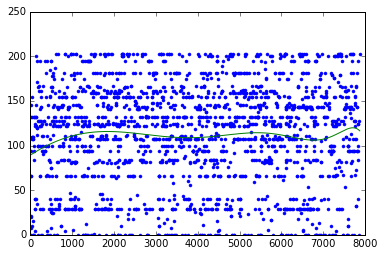

In [116]:
plot_fitted_line(set_1)

In [117]:
set_2_coef = get_coef(set_2)
print set_2_coef[set_2_coef['name'] == 'power_15']

Linear regression:

--------------------------------------------------------

Number of examples          : 2162

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.016000     | 118.414836         | 57.577975     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

+----------+-------+--------------------+-------------------+
|   name   | index |       value        |       stderr      |
+----------+-------+--------------------+-------------------+
| power_15 |  None | -1.24645940944e-56 | 8.35345908228e-52 |
+----------+-------+--------------------+-------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Linear regression:

--------------------------------------------------------

Number of examples          : 2162

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.016000     | 118.414836         | 57.577975     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

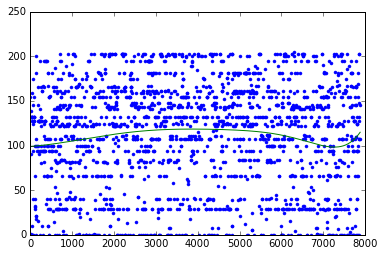

In [118]:
plot_fitted_line(set_2)

In [119]:
set_3_coef = get_coef(set_3)
print set_3_coef[set_3_coef['name'] == 'power_15']

Linear regression:

--------------------------------------------------------

Number of examples          : 2174

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.012000     | 114.138547         | 57.319494     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

+----------+-------+--------------------+-------------------+
|   name   | index |       value        |       stderr      |
+----------+-------+--------------------+-------------------+
| power_15 |  None | -2.71225760297e-56 | 4.99657732295e-52 |
+----------+-------+--------------------+-------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Linear regression:

--------------------------------------------------------

Number of examples          : 2174

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.012001     | 114.138547         | 57.319494     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

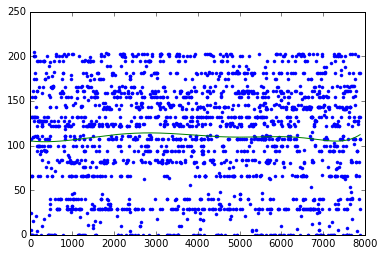

In [120]:
plot_fitted_line(set_3)

In [121]:
set_4_coef = get_coef(set_4)
print set_4_coef[set_4_coef['name'] == 'power_15']

Linear regression:

--------------------------------------------------------

Number of examples          : 2149

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.008002     | 113.978875         | 57.439869     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

+----------+-------+--------------------+-------------------+
|   name   | index |       value        |       stderr      |
+----------+-------+--------------------+-------------------+
| power_15 |  None | -4.39211331955e-56 | 4.77860763065e-52 |
+----------+-------+--------------------+-------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


Linear regression:

--------------------------------------------------------

Number of examples          : 2149

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.052004     | 113.978875         | 57.439869     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

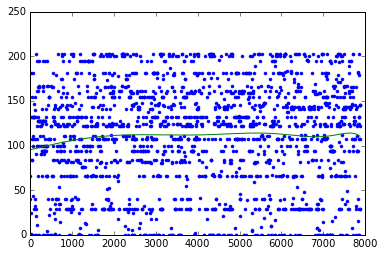

In [122]:
plot_fitted_line(set_4)

## Selecting a Polynomial Degree

Whenever we have a "magic" parameter like the degree of the polynomial there is one well-known way to select these parameters: validation set. (We will explore another approach in week 4).
We split the sales dataset 3-way into training set, test set, and validation set as follows:
- Split our sales data into 2 sets: training_and_validation and testing. Use random_split(0.9, seed=1).
- Further split our training data into two sets: training and validation. Use random_split(0.5, seed=1).

Again, we set seed=1 to obtain consistent results for different users.

In [124]:
training_and_validation_data, test_data = cuisine_newer.random_split(0.9, seed=1)
train_data, validation_data = training_and_validation_data.random_split(0.5, seed=1)

Next you should write a loop that does the following:
For degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] (to get this in python type range(1, 15+1))
Build an SFrame of polynomial data of train_data['ingred_label'] at the current degree
hint: my_features = poly_data.column_names() gives you a list e.g. ['power_1', 'power_2', 'power_3'] which you might find useful for graphlab.linear_regression.create( features = my_features)
Add train_data['cuisine_label'] to the polynomial SFrame
Learn a polynomial regression model to ingredients vs cuisines with that degree on TRAIN data
Compute the RSS on VALIDATION data (here you will want to use .predict()) for that degree and you will need to make a polynmial SFrame using validation data.
Report which degree had the lowest RSS on validation data (remember python indexes from 0)
(Note you can turn off the print out of linear_regression.create() with verbose = False)

In [125]:
arr = []
for degree in range(1, 16):
    poly_data = polynomial_sframe(train_data['ingred_label'], degree)      
    my_features = poly_data.column_names()
    poly_data['cuisine_label'] = train_data['cuisine_label']
    model = graphlab.linear_regression.create(poly_data, target = 'cuisine_label', features = my_features, 
                                              validation_set = None, verbose = False)
    validation_data_poly = polynomial_sframe(validation_data['ingred_label'], degree)
    predictions = model.predict(validation_data_poly)
    residuals = validation_data['cuisine_label'] - predictions
    rss = sum(residuals * residuals)
    arr.append(rss)
#     print degree
#     print rss 

# for degree, rss in enumerate(arr):
#     print degree, rss

# Note that list index starts from 0, so degree = index + 1
print arr.index(min(arr)), min(arr)

2 12278662.7578


### Which degree (1, 2, …, 15) had the lowest RSS on Validation data?

Now that you have chosen the degree of your polynomial using validation data, compute the RSS of this model on TEST data. Report the RSS on your quiz.

In [127]:
arr2 = []
for degree in range(1, 16):
    poly_data = polynomial_sframe(train_data['ingred_label'], degree)      
    my_features = poly_data.column_names()
    poly_data['cuisine_label'] = train_data['cuisine_label']
    model = graphlab.linear_regression.create(poly_data, target = 'cuisine_label', features = my_features, 
                                              validation_set = None, verbose = False)
    test_data_poly = polynomial_sframe(test_data['ingred_label'], degree)
    predictions = model.predict(test_data_poly)
    residuals = test_data['cuisine_label'] - predictions
    rss_test = sum(residuals * residuals)
    arr2.append(rss_test)
#     print degree
#     print rss 

for degree, rss in enumerate(arr2):
    print degree, rss

print arr2.index(min(arr2)), min(arr2)

0 3128163.85785
1 3127893.30643
2 3121815.57285
3 3125336.32795
4 3129786.89667
5 3135348.80205
6 3138999.34595
7 3140574.58298
8 3141192.11807
9 3141487.94133
10 3141585.72577
11 3141505.97231
12 3141304.31107
13 3141063.65147
14 3140862.08548
2 3121815.57285


#### What is the RSS on TEST data for the model with the degree selected from Validation data?

In [128]:
print arr2[2]

3138999.34595


## Ridge Regression

We will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
- Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression
- Use matplotlib to visualize polynomial regressions
- Use a pre-built implementation of regression (GraphLab Create) to run polynomial regression, this time with L2 penalty
- Use matplotlib to visualize polynomial regressions under L2 regularization
- Choose best L2 penalty using cross-validation.
- Assess the final fit using test data.

In [13]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = graphlab.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = feature ** power
    return poly_sframe

In [14]:
cuisine_newer_2 = cuisine_new.sort(['ingred_label','cuisine_label'])

Revisit the 15th-order polynomial model using the 'ingredients' input. Generate polynomial features up to degree 15 using polynomial_sframe() and fit a model with these features. When fitting the model, use an L2 penalty of 1e-5:

In [15]:
l2_small_penalty = 1e-5

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results. Thus, rather than using no regularization, we will introduce a tiny amount of regularization (l2_penalty=1e-5) to make the solution numerically stable. (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)
With the L2 penalty specified above, fit the model and print out the learned weights.

In [16]:
poly15_data = polynomial_sframe(cuisine_newer_2['ingred_label'], 15) # use equivalent of `polynomial_sframe`
poly15_features = poly15_data.column_names() # get the name of the features
poly15_data['cuisine_label'] = cuisine_newer_2['cuisine_label'] # add price to the data since it's the target

model1 = graphlab.linear_regression.create(poly15_data, target = 'cuisine_label', 
                                           features = poly15_features, l2_penalty=l2_small_penalty,
                                           validation_set=None,verbose=False)
model1.get("coefficients")

name,index,value,stderr
(intercept),None,106.577373634,6.88998632022
power_1,None,-0.0127080218101,0.0575126286296
power_2,None,4.64106530993e-06,3.83052253237e-05
power_3,None,1.07608886383e-08,nan
power_4,None,-6.30660232976e-12,nan
power_5,None,8.56086724848e-16,nan
power_6,None,6.35254229461e-20,nan
power_7,None,-9.22369217081e-24,nan
power_8,None,-1.55749767521e-27,nan
power_9,None,-2.79723661789e-32,nan


### Observe overfitting

Recall that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a high variance. We will see in a moment that ridge regression reduces such variance.

First, split the data into split the data into four subsets of roughly equal size and call them set_1, set_2, set_3, and set_4. Use .random_split function and make sure you set seed=0.

In [17]:
(semi_split1, semi_split2) = cuisine_newer_2.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

Fit a 15th degree polynomial on set_1, set_2, set_3, and set_4, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.
Hint: When calling graphlab.linear_regression.create(), use the same L2 penalty as before (i.e. l2_small_penalty). Also, make sure GraphLab Create doesn't create its own validation set by using the option validation_set = None in this call.

In [18]:
def get_poly_model(set_data, l2_penalty):
    poly15_data = polynomial_sframe(set_data['ingred_label'], 15)
    poly15_features = poly15_data.column_names() # get the name of the features
    poly15_data['cuisine_label'] = set_data['cuisine_label'] # add price to the data since it's the target
    model15 = graphlab.linear_regression.create(poly15_data, target = 'cuisine_label', features = poly15_features, 
                                                l2_penalty=l2_penalty,
                                                validation_set=None,verbose=False)
    return poly15_data, model15


def get_coef(set_data, l2_penalty):
    poly15_data, model15 = get_poly_model(set_data, l2_penalty)
    return model15.get("coefficients")

def plot_fitted_line(set_data, l2_penalty):
    poly15_data, model15 = get_poly_model(set_data, l2_penalty)
    return plt.plot(poly15_data['power_1'],poly15_data['cuisine_label'],'.',
           poly15_data['power_1'], model15.predict(poly15_data),'-')

+---------+-------+------------------+--------+
|   name  | index |      value       | stderr |
+---------+-------+------------------+--------+
| power_1 |  None | -0.0245969763914 |  nan   |
+---------+-------+------------------+--------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


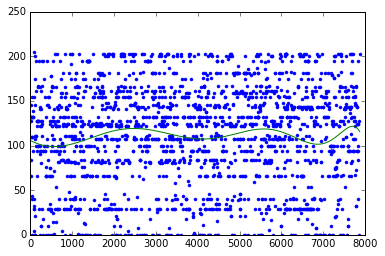

In [22]:
set_1_coef = get_coef(set_1, l2_small_penalty)
print set_1_coef[set_1_coef['name'] == 'power_1']
plot_fitted_line(set_1, l2_small_penalty)

+---------+-------+------------------+----------------+
|   name  | index |      value       |     stderr     |
+---------+-------+------------------+----------------+
| power_1 |  None | -0.0875677362956 | 0.187646910692 |
+---------+-------+------------------+----------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


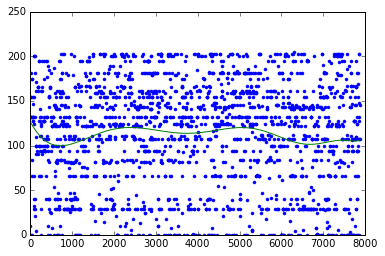

In [23]:
set_2_coef = get_coef(set_2, l2_small_penalty)
print set_2_coef[set_2_coef['name'] == 'power_1']
plot_fitted_line(set_2, l2_small_penalty)

+---------+-------+----------------+---------------+
|   name  | index |     value      |     stderr    |
+---------+-------+----------------+---------------+
| power_1 |  None | 0.023592214503 | 0.27390931124 |
+---------+-------+----------------+---------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


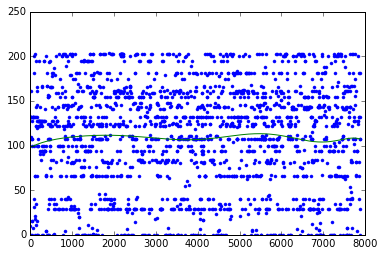

In [24]:
set_3_coef = get_coef(set_3, l2_small_penalty)
print set_3_coef[set_3_coef['name'] == 'power_1']
plot_fitted_line(set_3, l2_small_penalty)

+---------+-------+------------------+----------------+
|   name  | index |      value       |     stderr     |
+---------+-------+------------------+----------------+
| power_1 |  None | 0.00156774217157 | 0.174056689222 |
+---------+-------+------------------+----------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


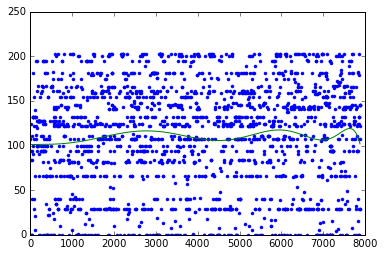

In [25]:
set_4_coef = get_coef(set_4, l2_small_penalty)
print set_4_coef[set_4_coef['name'] == 'power_1']
plot_fitted_line(set_4, l2_small_penalty)

### Ridge regression comes to rescue **Variance**

Whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of model15 looked quite small, but they are not that small because 'ingred_label' input is in the order of thousands.)

With the argument l2_penalty=1e5, fit a 15th-order polynomial model on set_1, set_2, set_3, and set_4. Other than the change in the l2_penalty parameter, the code should be the same as the experiment above. Also, make sure GraphLab Create doesn't create its own validation set by using the option validation_set = None in this call.

In [26]:
l2_new_penalty = 1e5

+---------+-------+-------------------+--------+
|   name  | index |       value       | stderr |
+---------+-------+-------------------+--------+
| power_1 |  None | 4.12361982905e-06 |  nan   |
+---------+-------+-------------------+--------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


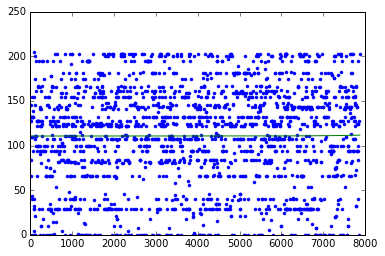

In [27]:
set_1_coef = get_coef(set_1, l2_new_penalty)
print set_1_coef[set_1_coef['name'] == 'power_1']
plot_fitted_line(set_1, l2_new_penalty)

+---------+-------+--------------------+----------------+
|   name  | index |       value        |     stderr     |
+---------+-------+--------------------+----------------+
| power_1 |  None | -1.99078929624e-06 | 0.188998909266 |
+---------+-------+--------------------+----------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


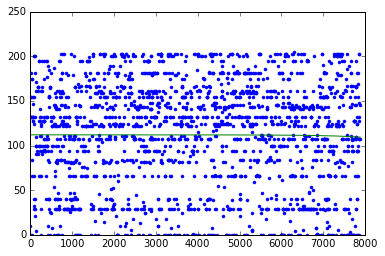

In [28]:
set_2_coef = get_coef(set_2, l2_new_penalty)
print set_2_coef[set_2_coef['name'] == 'power_1']
plot_fitted_line(set_2, l2_new_penalty)

+---------+-------+-------------------+----------------+
|   name  | index |       value       |     stderr     |
+---------+-------+-------------------+----------------+
| power_1 |  None | 1.75877905728e-07 | 0.274293939237 |
+---------+-------+-------------------+----------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


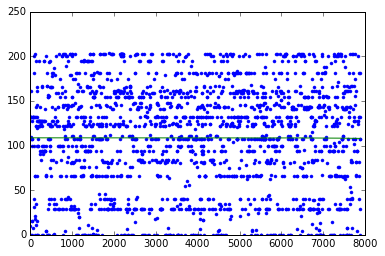

In [29]:
set_3_coef = get_coef(set_3, l2_new_penalty)
print set_3_coef[set_3_coef['name'] == 'power_1']
plot_fitted_line(set_3, l2_new_penalty)

+---------+-------+-------------------+----------------+
|   name  | index |       value       |     stderr     |
+---------+-------+-------------------+----------------+
| power_1 |  None | 5.26364702048e-06 | 0.174759395177 |
+---------+-------+-------------------+----------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


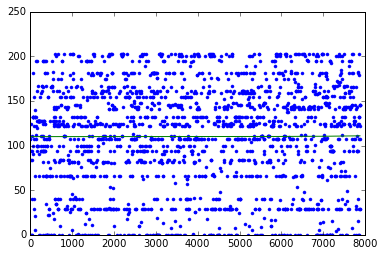

In [30]:
set_4_coef = get_coef(set_4, l2_new_penalty)
print set_4_coef[set_4_coef['name'] == 'power_1']
plot_fitted_line(set_4, l2_new_penalty)

These curves should vary a lot less, now that we applied a high degree of regularization.

## Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. Cross-validation seeks to overcome this issue by using all of the training set in a smart way.
We will implement a kind of cross-validation called k-fold cross-validation. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:
Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set
...
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set
After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that all observations are used for both training and validation, as we iterate over segments of data.
To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. GraphLab Create has a utility function for shuffling a given SFrame. We reserve 10% of the data as the test set and shuffle the remainder. (Make sure to use seed=1 to get consistent answer.)

In [31]:
(train_valid, test) = cuisine_newer_2.random_split(.9, seed=1)
train_valid_shuffled = graphlab.toolkits.cross_validation.shuffle(train_valid, random_seed=1)

Once the data is shuffled, we divide it into equal segments. Each segment should receive n/k elements, where n is the number of observations in the training set and k is the number of segments. Since the segment 0 starts at index 0 and contains n/k elements, it ends at index (n/k)-1. The segment 1 starts where the segment 0 left off, at index (n/k). With n/k elements, the segment 1 ends at index (n*2/k)-1. Continuing in this fashion, we deduce that the segment i starts at index (n*i/k) and ends at (n*(i+1)/k)-1.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [32]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in xrange(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1    
    print i, (start, end)

0 (0, 778)
1 (779, 1557)
2 (1558, 2337)
3 (2338, 3116)
4 (3117, 3896)
5 (3897, 4675)
6 (4676, 5454)
7 (5455, 6234)
8 (6235, 7013)
9 (7014, 7793)


In [33]:
train_valid_shuffled[0:10] # rows 0 to 9

X1,id,recipeName,rating,totalTimeInSeconds,course
227,Lynchburg-Lemonade-Allrecipes ...,Lynchburg Lemonade,4,300.0,"[Beverages, Cocktails]"
222,Mojito-My-Recipes_4,Mojito,3,1200.0,"[Beverages, Cocktails]"
457,Salmon-Shioyaki-MyRecipes-245614 ...,Salmon Shioyaki,4,8100.0,[Main Dishes]
364,Honey-Syrup-Allrecipes,Honey Syrup,4,1800.0,None
85,Maple-meatballs-370089,Maple Meatballs,5,1200.0,None
241,Teriyaki-Mushroom-Bowl-1341391 ...,Teriyaki Mushroom Bowl,4,1500.0,[]
125,MEDITERRANEAN-FIORELLI-PASTA-SALAD-1325242 ...,MEDITERRANEAN FIORELLIPASTA SALAD ...,4,1500.0,[Salads]
95,Tropical-Salad-With-Pineapple-Vinaigrette- ...,Tropical Salad withPineapple Vinaigrette ...,5,1800.0,[Salads]
344,Caramel-Sauce-Martha-Stewart-191188 ...,Caramel Sauce,4,900.0,"[Desserts, Condiments andSauces] ..."
485,Cajun-Shrimp-Boil-Foil-Packets-1212171 ...,Cajun Shrimp Boil FoilPackets ...,4,1800.0,[Main Dishes]


Now let us extract individual segments with array slicing. Consider the scenario where we group the cuisines in the train_valid_shuffled dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above. Extract the fourth segment (segment 3) and assign it to a variable called validation4.

In [34]:
print len(train_valid_shuffled)

7794


In [35]:
# start = (n*i)/k
# end = (n*(i+1))/k-1
# validation4 = train_valid_shuffled[(n*3)/k : (n*(3+1))/k-1] #5818, 7757
validation4 = train_valid_shuffled[2888 : 3851]

After designating one of the k segments as the validation set, we train a model using the rest of the data. To choose the remainder, we slice (0:start) and (end+1:n) of the data and paste them together. SFrame has append() method that pastes together two disjoint sets of rows originating from a common dataset. For instance, the following cell pastes together the first and last two rows of the train_valid_shuffled dataframe.

In [36]:
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print first_two.append(last_two)

+-----+-------------------------------+-----------------------+--------+--------------------+
|  X1 |               id              |       recipeName      | rating | totalTimeInSeconds |
+-----+-------------------------------+-----------------------+--------+--------------------+
| 227 | Lynchburg-Lemonade-Allrecipes |   Lynchburg Lemonade  |   4    |       300.0        |
| 222 |      Mojito-My-Recipes_4      |         Mojito        |   3    |       1200.0       |
| 427 | Japanese-Fish-Tacos-MyReci... |  Japanese Fish Tacos  |   4    |       6300.0       |
| 266 | Chinese-Fried-Walnuts-Allr... | Chinese Fried Walnuts |   5    |       2700.0       |
+-----+-------------------------------+-----------------------+--------+--------------------+
+------------------------+------------------------+
|         course         |        cuisine         |
+------------------------+------------------------+
| [Beverages, Cocktails] | [Southern & Soul Food] |
| [Beverages, Cocktails] |        [Cuban

Extract the remainder of the data after excluding fourth segment (segment 3) and assign the subset to train4.

In [37]:
first_part = train_valid_shuffled[0:2887]
last_part = train_valid_shuffled[3852:]
train4 = first_part.append(last_part)
print len(train4)

6829


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) k, (ii) l2_penalty, (iii) dataframe, (iv) name of output column (e.g. cuisine) and (v) list of feature names. The function returns the average validation error using k segments as validation sets.
- For each i in [0, 1, ..., k-1]:
- Compute starting and ending indices of segment i and call 'start' and 'end'
- Form validation set by taking a slice (start:end+1) from the data.
- Form training set by appending slice (end+1:n) to the end of slice (0:start).
- Train a linear model using training set just formed, with a given l2_penalty
- Compute validation error using validation set just formed

In [41]:
import numpy as np
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):    
    rss_sum = 0
    n = len(data)
    for i in xrange(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation_set = data[start:end+1]
        training_set = data[0:start].append(data[end+1:n])    
        model = graphlab.linear_regression.create(training_set, target = output_name, features = features_list, 
                                                  l2_penalty=l2_penalty,
                                                  validation_set=None,verbose=False)
        predictions = model.predict(validation_set)
        residuals = validation_set['cuisine_label'] - predictions
        rss = sum(residuals * residuals)
        rss_sum += rss
    validation_error = rss_sum / k # average = sum / size or you can use np.mean(list_of_validation_error)
    return validation_error   

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
- We will again be aiming to fit a 15th-order polynomial model using the ingredients input
- For l2_penalty in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: np.logspace(1, 7, num=13).)
- Run 10-fold cross-validation with l2_penalty
- Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use train_valid_shuffled when generating polynomial features!

In [42]:
poly_data = polynomial_sframe(train_valid_shuffled['ingred_label'], 15)
my_features = poly_data.column_names()
poly_data['cuisine_label'] = train_valid_shuffled['cuisine_label']

val_err_dict = {}
for l2_penalty in np.logspace(1, 7, num=13):
    val_err = k_fold_cross_validation(10, l2_penalty, poly_data, 'cuisine_label', my_features)    
    print l2_penalty#, val_err
    val_err_dict[l2_penalty] = val_err
print val_err_dict

10.0
31.6227766017
100.0
316.227766017
1000.0
3162.27766017
10000.0
31622.7766017
100000.0
316227.766017
1000000.0
3162277.66017
10000000.0
{100000.0: 2561331.531745662, 316227.76601683791: 2561272.1007872312, 100.0: 2556977.748377812, 3162.2776601683795: 2560681.8495126273, 31.622776601683793: 2556919.7700701253, 1000.0: 2559301.109779182, 10.0: 2556919.248016686, 31622.776601683792: 2561388.7234542468, 10000.0: 2561271.732684874, 3162277.6601683791: 2561238.1839375347, 316.2277660168379: 2557687.720299865, 1000000.0: 2561246.6977348044, 10000000.0: 2561235.467295726}


In [43]:
import pprint 
pprint.pprint(val_err_dict)

{10.0: 2556919.248016686,
 31.622776601683793: 2556919.7700701253,
 100.0: 2556977.748377812,
 316.2277660168379: 2557687.720299865,
 1000.0: 2559301.109779182,
 3162.2776601683795: 2560681.8495126273,
 10000.0: 2561271.732684874,
 31622.776601683792: 2561388.7234542468,
 100000.0: 2561331.531745662,
 316227.76601683791: 2561272.1007872312,
 1000000.0: 2561246.6977348044,
 3162277.6601683791: 2561238.1839375347,
 10000000.0: 2561235.467295726}


In [44]:
print min(val_err_dict.items(), key=lambda x: x[1]) 

(10.0, 2556919.248016686)


In [45]:
min_val = min(val_err_dict.itervalues())
print min_val

2556919.24802


In [46]:
print min(val_err_dict, key=val_err_dict.get)

10.0


### What is the best value for the L2 penalty according to 10-fold validation?

We may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method.

In [47]:
l2_penalty = graphlab.SArray(val_err_dict.keys())
validation_error = graphlab.SArray(val_err_dict.values())

sf = graphlab.SFrame({'l2_penalty':l2_penalty,'validation_error':validation_error})
print sf

+---------------+------------------+
|   l2_penalty  | validation_error |
+---------------+------------------+
|    100000.0   |  2561331.53175   |
| 316227.766017 |  2561272.10079   |
|     100.0     |  2556977.74838   |
| 3162.27766017 |  2560681.84951   |
| 31.6227766017 |  2556919.77007   |
|     1000.0    |  2559301.10978   |
|      10.0     |  2556919.24802   |
| 31622.7766017 |  2561388.72345   |
|    10000.0    |  2561271.73268   |
| 3162277.66017 |  2561238.18394   |
+---------------+------------------+
[13 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


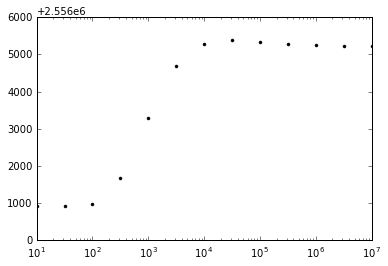

In [48]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.

plt.plot(sf['l2_penalty'],sf['validation_error'],'k.')
plt.xscale('log')

Once we found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of l2_penalty. This way, your final model will be trained on the entire dataset.

In [49]:
poly_data = polynomial_sframe(train_valid_shuffled['ingred_label'], 15)
features_list = poly_data.column_names()
poly_data['cuisine_label'] = train_valid_shuffled['cuisine_label']
l2_penalty_best = 1000.0

model = graphlab.linear_regression.create(poly_data, target='cuisine_label',
                                         features=features_list,
                                         l2_penalty=l2_penalty_best,
                                         validation_set=None)

Linear regression:

--------------------------------------------------------

Number of examples          : 7794

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.023017     | 111.924917         | 57.279487     |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

### Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty?

In [50]:
poly_test = polynomial_sframe(test['ingred_label'], 15)
predictions = model.predict(poly_test)
errors = predictions-test['cuisine_label']
rss = (errors*errors).sum()
print rss

2835161.61307


In [51]:
import numpy as np

In [52]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [53]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

### Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.

+ Cost(w)
+ = SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part. As we saw, the derivative of the RSS with respect to w[i] can be written as:

- 2*SUM[ error*[feature_i] ].

The derivative of the regularization term with respect to w[i] is:
- 2*l2_penalty*w[i].
Summing both, we get
- 2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus 2*l2_penalty*w[i].

We will not regularize the constant. Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the 2*l2_penalty*w[0] term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus 2*l2_penalty*w[i].

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points). To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call feature_is_constant which you should set to True when computing the derivative of the constant and False otherwise.

In [54]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)
    return derivative

To test your feature derivartive run the following:

In [56]:
(example_features, example_output) = get_numpy_data(cuisine_new, ['ingred_label'], 'cuisine_label') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

3.58575954728e+12
3.58575954728e+12

681755874.0
681755874.0


## Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.
The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a maximum number of iterations and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)
With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [57]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1            
    return weights

## Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [58]:
simple_features = ['ingred_label']
my_output = 'cuisine_label'

In [61]:
train_data,test_data = cuisine_new.random_split(.8,seed=0)

In this part, we will only use ingredients to predict 'Cuisines'. Use the get_numpy_data function to get a Numpy versions of your data with only this feature, for both the train_data and the test_data.

In [62]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [63]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization. Set the l2_penalty to 0.0 and run your ridge regression algorithm to learn the weights of your model. Call your weights:
simple_weights_0_penalty
we'll use them later.

In [64]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
print simple_weights_0_penalty

[ 0.00038471  0.02097623]


Next, let's consider high regularization. Set the l2_penalty to 1e11 and run your ridge regression algorithm to learn the weights of your model. Call your weights:
simple_weights_high_penalty
we'll use them later.

In [65]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             1e11, max_iterations)
print simple_weights_high_penalty

[ 0.00085386  0.0124041 ]


### This code will plot the two learned models. (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

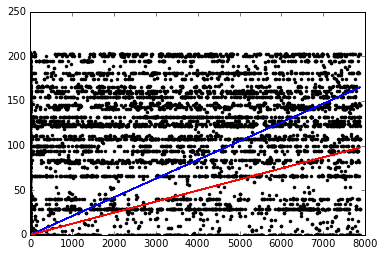

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:

1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [68]:
initial_predictions = predict_output(simple_test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

26527172.0


In [69]:
regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

10505951.2617


In [70]:
no_regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

13335859.588


## Part 3 of Project(Enhancing K- nearest neighbor Regression model)

In [74]:
cuisine_newer = graphlab.SFrame.read_csv('cuisinedata/cuisine_data_shredded.csv')

Finished parsing file C:\Users\dell\cuisinedata\cuisine_data_shredded.csv

Parsing completed. Parsed 100 lines in 1.42892 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,str,str,long,long,list,list,list]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\dell\cuisinedata\cuisine_data_shredded.csv

Parsing completed. Parsed 8338 lines in 0.680334 secs.

In [78]:
# convert cuisines to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_newer['cuisine'])
cuisine_newer['cuisine_label'] = le.transform(cuisine_newer['cuisine'])

In [79]:
# convert ingredients to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisine_newer['ingredients'])
cuisine_newer['ingred_label'] = le.transform(cuisine_newer['ingredients'])

In [80]:
cuisine_newer.head()

X1,id,recipeName,rating,totalTimeInSeconds,course
0,Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600,None
1,Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100,[Desserts]
2,Buckeyes-298471,Buckeyes,4,6600,[Desserts]
3,Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100,[Appetizers]
4,Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500,"[Salads, Side Dishes]"
5,Classic-coleslaw-303481,Classic Coleslaw,4,600,"[Salads, Side Dishes]"
6,Bechamel-Sauce-513101,Béchamel Sauce,5,1200,[Condiments and Sauces]
7,Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700,[Desserts]
8,Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800,[Desserts]
9,Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600,[Desserts]


We will also need the normalize_features() function that normalizes all feature columns to unit norm. Paste this function below.

In [71]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return (normalized_features, norms)

### Split data into training, test, and validation sets

In [81]:
(train_and_validation, test) = cuisine_newer.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

### Extract features and normalize

In [82]:
feature_list = ['ingred_label','totalTimeInSeconds']

In [83]:
features_train, output_train = get_numpy_data(train, feature_list, 'cuisine_label')
features_test, output_test = get_numpy_data(test, feature_list, 'cuisine_label')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'cuisine_label')

In computing distances, it is crucial to normalize features. Otherwise, for example, the Cooking time feature (typically on the order of thousands) would exert a much larger influence on distance than the ingredinets feature (typically on the order of ones). We divide each column of the training feature matrix by its 2-norm, so that the transformed column has unit norm.
IMPORTANT: Make sure to store the norms of the features in the training set. The features in the test and validation sets must be divided by these same norms, so that the training, test, and validation sets are normalized consistently.

In [84]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

### Compute a single distance

To start, let's just explore computing the "distance" between two given Cuisines. We will take our query dish to be the first dish of the test set and look at the distance between this dish and the 10th dish of the training set.
To see the features associated with the query dish, print the first row (index 0) of the test feature matrix. You should get an 3-dimensional vector whose components are between 0 and 1.

In [85]:
print features_test[0]

[ 0.01375423  0.01668249  0.00969302]


Now print the 10th row (index 9) of the training feature matrix. Again, you get an 3-dimensional vector with components between 0 and 1.

In [86]:
print features_train[9]

[ 0.01375423  0.02202529  0.00424069]


- Slide 16

Euclidean distance:
$distance(x_j, x_q) \sqrt{a_1(x_j[1]-x_q[1])^2 + ... + a_d(x_j[d]-x_q[d])^2)}$

In [87]:
euclidean_distance = np.sqrt(np.sum((features_train[9] - features_test[0])**2))
print euclidean_distance

0.0076336959024


### Computing multiple distances

Of course, to do nearest neighbor regression, we need to compute the distance between our query cuisne and all cuisines in the training set.
To visualize this nearest-neighbor search, let's first compute the distance from our query cuisine (features_test[0]) to the first 10 cuisines of the training set (features_train[0:10]) and then search for the nearest neighbor within this small set of cuisines. Through restricting ourselves to a small set of cuisines to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.
Write a loop to compute the Euclidean distance from the query cuisines to each of the first 10 cuisines in the training set.

In [88]:
dist_dict = {}
for i in range(0,10):
    dist_dict[i] = np.sqrt(np.sum((features_train[i] - features_test[0])**2))
    print (i, np.sqrt(np.sum((features_train[i] - features_test[0])**2)))

(0, 0.012593896950856909)
(1, 0.017867903089450847)
(2, 0.01675141733569056)
(3, 0.0065548203342353705)
(4, 0.010445827797398732)
(5, 0.0097885134391900094)
(6, 0.018189012346022104)
(7, 0.021486014184800766)
(8, 0.01586660575207393)
(9, 0.0076336959024045498)


Among the first 10 training cuisines, which cuisine is the closest to the query cuisine?

In [90]:
print min(dist_dict.items(), key=lambda x: x[1]) 

(3, 0.0065548203342353705)


It is computationally inefficient to loop over computing distances to all cuisines in our training dataset. Fortunately, many of the Numpy functions can be vectorized, applying the same operation over multiple values or vectors. We now walk through this process.

Consider the following loop that computes the element-wise difference between the features of the query house (features_test[0]) and the first 3 training houses (features_train[0:3]):

In [91]:
for i in xrange(3):
    print features_train[i]-features_test[0]
    # should print 3 vectors of length 3

[ 0.         -0.01235856 -0.00242325]
[ 0.         -0.01657871  0.00666395]
[ 0.         -0.0163523   0.00363488]


The subtraction operator (-) in Numpy is vectorized as follows:

In [92]:
print features_train[0:3] - features_test[0]

[[ 0.         -0.01235856 -0.00242325]
 [ 0.         -0.01657871  0.00666395]
 [ 0.         -0.0163523   0.00363488]]


Note that the output of this vectorized operation is identical to that of the loop above, which can be verified below:

In [93]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print results[0] - (features_train[0]-features_test[0])
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print results[1] - (features_train[1]-features_test[0])
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print results[2] - (features_train[2]-features_test[0])
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.  0.  0.]


Aside: it is a good idea to write tests like this cell whenever you are vectorizing a complicated operation.

### Perform 1-nearest neighbor regression

Now that we have the element-wise differences, it is not too hard to compute the Euclidean distances between our query cuisines and all of the training cuisines. First, write a single-line expression to define a variable diff such that diff[i] gives the element-wise difference between the features of the query cuisine and the i-th training cuisine.


In [94]:
diff = features_train - features_test[0]

In [97]:
print diff[-1].sum() # sum of the feature differences between the query and last training cuisines

-0.00172459691178


The next step in computing the Euclidean distances is to take these feature-by-feature differences in diff, square each, and take the sum over feature indices. That is, compute the sum of square feature differences for each training cuisine (row in diff).
By default, np.sum sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the axis parameter described in the np.sum documentation. In particular, axis=1 computes the sum across each row.
Below, we compute this sum of square feature differences for all training cuisines and verify that the output for the 16th cuisine in the training set is equivalent to having examined only the 16th row of diff and computing the sum of squares on that row alone.

In [98]:
print np.sum(diff**2, axis=1)[15] # take sum of squares across each row, and print the 16th sum
print np.sum(diff[15]**2) # print the sum of squares for the 16th row -- should be same as above

0.000110519298057
0.000110519298057


With this result in mind, write a single-line expression to compute the Euclidean distances between the query house and all houses in the training set. Assign the result to a variable distances.
taking the square root of the sum of squares.

In [99]:
distances = np.sqrt(np.sum(diff**2, axis=1))

In [100]:
print distances[100] # Euclidean distance between the query cuisine and the 101th training cuisine

0.0122617573231


Now you are ready to write a function that computes the distances from a query cuisine to all training houses. The function should take two parameters: (i) the matrix of training features and (ii) the single feature vector associated with the query.

In [101]:
def compute_distances(train_matrix, query_vector):
    diff = train_matrix - query_vector
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

1. Take the query cuisine to be third cuisine of the test set (features_test[2]). What is the index of the cuisine in the training set that is closest to this query cuisine?
2. What is the predicted value of the query cuisine based on 1-nearest neighbor regression?

In [102]:
third_cuisine_distance = compute_distances(features_train, features_test[2])
print third_cuisine_distance.argsort()[:1], min(third_cuisine_distance)
print third_cuisine_distance[382]

[3622] 1.57233625831e-05
0.0148201384126


In [103]:
print np.argsort(third_cuisine_distance, axis = 0)[:4]

[3622  440 4441 3982]


In [104]:
print output_train[382]

26


### Perform k-nearest neighbor regression

For k-nearest neighbors, we need to find a set of k cuisines in the training set closest to a given query cuisine. We then make predictions based on these k nearest neighbors.

### Fetch k-nearest neighbors

Using the functions above, implement a function that takes in
- the value of k;
- the feature matrix for the training cuisines; and
- the feature vector of the query cuisine

and returns the indices of the k closest training cuisines. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training cuisines are closest to the query cuisine

In [105]:
def compute_k_nearest_neighbors(k, features_matrix, feature_vector):
    distances = compute_distances(features_matrix, feature_vector)
    return np.argsort(distances, axis = 0)[:k]

Take the query cuisine to be third cuisine of the test set (features_test[2]). What are the indices of the 4 training cuisines closest to the query cuisine?

In [106]:
print compute_k_nearest_neighbors(4, features_train, features_test[2])

[3622  440 4441 3982]


### Make a single prediction by averaging k nearest neighbor outputs

Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query cuisine. For simplicity, take the average of the cuisine_labels of the k nearest neighbors in the training set. The function should have the following parameters:
- the value of k;
- the feature matrix for the training cuisine;
- the output values (prices) of the training cuisine; and
- the feature vector of the query cuisine, whose dish we are predicting.

The function should return a predicted value of the query cuisine.
Hint: You can extract multiple items from a Numpy array using a list of indices. For instance, output_train[[6, 10]] returns the cuisnes of the 7th and 11th training cuisines

In [107]:
def compute_distances_k_avg(k, features_matrix, output_values, feature_vector):
    k_neigbors = compute_k_nearest_neighbors(k, features_matrix, feature_vector)
    avg_value = np.mean(output_values[k_neigbors])
    return avg_value

Again taking the query cuisine to be third cuisine of the test set (features_test[2]), predict the value of the query cuisine using k-nearest neighbors with k=4 and the simple averaging method described and implemented above.

In [108]:
print compute_distances_k_avg(4, features_train, output_train, features_test[2])

121.25


### Make multiple predictions

Write a function to predict the value of each and every cuisine in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each cuisine in the query set as the query cuisine and make a prediction for that specific cuisine. The new function should take the following parameters:
- the value of k;
- the feature matrix for the training cuisines;
- the output values of the training cuisines; and
- the feature matrix for the query set.
The function should return a set of predicted values, one for each cuisines in the query set.

In [109]:
print features_test[0:10].shape[0]

10


In [110]:
def compute_distances_k_all(k, features_matrix, output_values, feature_vector):
    num_of_rows = feature_vector.shape[0]
    predicted_values = []
    for i in xrange(num_of_rows):
        avg_value = compute_distances_k_avg(k, features_train, output_train, features_test[i])
        predicted_values.append(avg_value)
    return predicted_values

Make predictions for the first 10 cuisines in the test set using k-nearest neighbors with k=10.

In [111]:
predicted_values = compute_distances_k_all(10, features_train, output_train, features_test[0:10])
print predicted_values
print predicted_values.index(min(predicted_values))

[119.5, 115.59999999999999, 108.5, 104.3, 96.5, 74.900000000000006, 58.799999999999997, 100.2, 115.90000000000001, 88.099999999999994]
6


### Choosing the best value of k using a validation set

There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:
* For k in [1, 2, ..., 15]:
    * Makes predictions for each cuisine in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
    * Computes the RSS for these predictions on the VALIDATION set
    * Stores the RSS computed above in rss_all
* Report which k produced the lowest RSS on VALIDATION set.

In [112]:
rss_all = []
for k in range(1,16):    
    predict_value = compute_distances_k_all(k, features_train, output_train, features_valid)
    residual = (output_valid - predict_value)
    rss = sum(residual**2)
    rss_all.append(rss)

In [113]:
print rss_all

[8122932.0, 6067665.5, 5428599.8888889141, 5049718.4375, 4913754.2800000003, 4768628.72222225, 4699910.1428571399, 4613260.75, 4588208.7901234701, 4554352.0600000024, 4509283.9669421539, 4475724.2430555793, 4459283.9585798765, 4440294.0255102059, 4403387.7822222244]


In [114]:
print rss_all.index(min(rss_all))

14


To visualize the performance as a function of k, plot the RSS on the VALIDATION set for each considered k value:

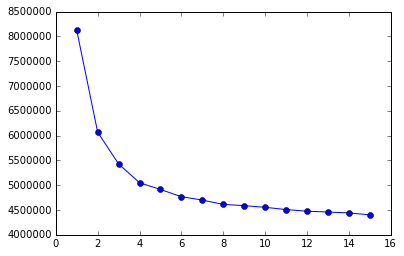

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

What is the RSS on the TEST data using the value of k found above? To be clear, sum over all houses in the TEST set.

In [116]:
predict_value = compute_distances_k_all(14, features_train, output_train, features_test)
residual = (output_test - predict_value)
rss = sum(residual**2)
print rss

5217305.94898


# Part 4 of Project

In [175]:
cuisines = graphlab.SFrame.read_csv('cuisinedata/cuisinedata.csv')

Finished parsing file C:\Users\dell\cuisinedata\cuisinedata.csv

Parsing completed. Parsed 100 lines in 0.87206 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,long,long,list,list,list,long,long,long,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file C:\Users\dell\cuisinedata\cuisinedata.csv

Parsing completed. Parsed 8338 lines in 0.624053 secs.

In [127]:
import csv

with open('cuisine_data.csv','r') as csvinput:
    with open('output1.csv', 'w') as csvoutput:
        writer = csv.writer(csvoutput, lineterminator='\n')
        reader = csv.reader(csvinput)

        all = []
        row = next(reader)
        row.append('calories')
        all.append(row)

        for row in reader:
            row.append(random.randint(49,1000))
            all.append(row)

        writer.writerows(all)

In [176]:
cuisines

id,recipeName,rating,totalTimeInSeconds,course
Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600,None
Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100,[Desserts]
Buckeyes-298471,Buckeyes,4,6600,[Desserts]
Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100,[Appetizers]
Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500,"[Salads, Side Dishes]"
Classic-coleslaw-303481,Classic Coleslaw,4,600,"[Salads, Side Dishes]"
Bechamel-Sauce-513101,Béchamel Sauce,5,1200,[Condiments and Sauces]
Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700,[Desserts]
Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800,[Desserts]
Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600,[Desserts]


### Exploring the target column
The target column (label column) of the dataset that we are interested in is called healthy. In this column 1 means healthy dish and 0 means an unhealthy dish.
In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
- +1 as a healthy dish,
- -1 as a unhealthy dish.

We put this in a new column called healthy.

In [8]:
# healthy_cuisine =  1 => healthy
# unhealthy_cuisine = -1 => unhealthy
cuisines['healthy'] = cuisines['calories'].apply(lambda x : +1 if x>=500 else -1)

In [178]:
cuisines

id,recipeName,rating,totalTimeInSeconds,course
Southern-Cornbread-Dressing-1357820 ...,Southern CornbreadDressing ...,4,3600,None
Peanut-butter-fudge-297693 ...,Peanut Butter Fudge,4,8100,[Desserts]
Buckeyes-298471,Buckeyes,4,6600,[Desserts]
Disappearing-buffalo-chicken-dip-297712 ...,Disappearing BuffaloChicken Dip ...,4,2100,[Appetizers]
Classic-macaroni-salad-304692 ...,Classic Macaroni Salad,4,1500,"[Salads, Side Dishes]"
Classic-coleslaw-303481,Classic Coleslaw,4,600,"[Salads, Side Dishes]"
Bechamel-Sauce-513101,Béchamel Sauce,5,1200,[Condiments and Sauces]
Peanut-butter-cream-pie-298882 ...,Peanut Butter Cream Pie,4,11700,[Desserts]
Southern-Pecan-Pie-1332202 ...,Southern Pecan Pie,4,4800,[Desserts]
Peanut-Butter-Fudge-482257 ...,Peanut Butter Fudge,4,600,[Desserts]


Now, let us explore the distribution of the column healthy dishes. This gives us a sense of how many safe and risky dishes are present in the dataset.

In [9]:
graphlab.canvas.set_target('ipynb')
cuisines['healthy'].show(view = 'Categorical')

### Features for the classification algorithm

In [10]:
features = ['ingred_label', 'totalTimeInSeconds', 'ingred_count', 'rating', 'cuisine_label']
target = 'healthy'

cuisines_1 = cuisines[features + [target]]

What remains now is a subset of features and the target that we will use for the rest 

In [181]:
cuisines_1

ingred_label,totalTimeInSeconds,ingred_count,rating,cuisine_label,healthy
1369,3600,11,4,167,-1
33,8100,5,4,25,-1
105,6600,4,4,25,1
4148,2100,7,4,25,-1
2747,1500,13,4,25,1
3751,600,7,4,22,-1
3,1200,6,5,8,-1
104,11700,6,4,25,1
5305,4800,7,4,161,-1
6896,600,5,4,25,1


In [11]:
train_data, validation_data = cuisines_1.random_split(.8, seed=1)

Saving data to csv

In [165]:
cuisines_2 = pd.read_csv('cuisinedata\cuisinedata_new.csv', index_col = 'id')

In [166]:
# convert ingredients to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines_2['ingredients'])
cuisines_2['ingred_label'] = le.transform(cuisines_2['ingredients'])

In [167]:
# convert cuisines to integer labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(cuisines_2['cuisine'])
cuisines_2['cuisine_label'] = le.transform(cuisines_2['cuisine'])

In [168]:
# convert ingredients from str to list
ingred = cuisines_2['ingredients'].values
ingredlist = []
for i in range(0, len(ingred)):
    ingredlist.append([x.strip() for x in ingred[i][1:-1].split(',')])
# store ingredient count for each recipe
ingredcount = []
for i in range(0, len(ingredlist)):
    ingredcount.append(len(ingredlist[i]))
cuisines_2['ingred_count'] = ingredcount

In [169]:
cuisines_2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [173]:
df = pd.DataFrame(cuisines_2)

In [174]:
df.to_csv('fileName.csv')

### Use decision tree to build a classifier
Now, let's use the built-in GraphLab Create decision tree learner to create a healthy prediction model on the training data.Later we will implement our own decision tree learning algorithm.) Our feature columns and target column have already been decided above. Use validation_set=None to get the same results as everyone else.

In [12]:
decision_tree_model = graphlab.decision_tree_classifier.create(train_data, validation_set=None,
                                target = target, features = features)

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 6655

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.122075     | 0.569346          | 0.684043          |

+-----------+--------------+-------------------+-------------------+

In [13]:
decision_tree_model.show(view="Tree")

### Visualizing a learned model
Typically the the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically. Here, we instead learn a smaller model with max depth of 2 to gain some intuition by visualizing the learned tree.

In [14]:
small_model = graphlab.decision_tree_classifier.create(train_data, validation_set=None,
                   target = target, features = features, max_depth = 2)

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 6655

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.012009     | 0.540195          | 0.690939          |

+-----------+--------------+-------------------+-------------------+

In the view that is provided by GraphLab Create, you can see each node, and each split at each node. This visualization is great for considering what happens when this model predicts the target of a new data point.
Note: To better understand this visual:
- The root node is represented using pink.
- Intermediate nodes are in green.
- Leaf nodes in blue and orange.

In [15]:
small_model.show(view="Tree")

## Making predictions
Let's consider two positive and two negative examples from the validation set and see what the model predicts. We will do the following:
- Predict whether or not a cuisine is healthy.
- Predict the probability that a cuisine is healthy.

In [187]:
validation_healthy = validation_data[validation_data[target] == 1]
validation_unhealthy = validation_data[validation_data[target] == -1]

sample_validation_data_unhealthy = validation_unhealthy[0:2]
sample_validation_data_healthy = validation_healthy[0:2]

sample_validation_data = sample_validation_data_healthy.append(sample_validation_data_unhealthy)
sample_validation_data

ingred_label,totalTimeInSeconds,ingred_count,rating,cuisine_label,healthy
6896,600,5,4,25,1
5303,6300,10,4,25,1
5305,4800,7,4,161,-1
1473,1800,5,4,25,-1


### Explore label predictions
Now, we will use our model to predict whether or not a cuisine is likely to be unhealthy. For each row in the sample_validation_data, use the decision_tree_model to predict whether or not the cuisine is classified as a healthy cuisine

In [188]:
decision_tree_model.predict(sample_validation_data)

dtype: int
Rows: 4
[1L, 1L, 1L, 1L]

What percentage of the predictions on sample_validation_data did decision_tree_model get correct?

In [189]:
(sample_validation_data['healthy'] == decision_tree_model.predict(sample_validation_data)).sum()/float(len(sample_validation_data))

0.5

### Explore probability predictions
For each row in the sample_validation_data, what is the probability (according decision_tree_model) of a cuisine being classified as healthy?

In [190]:
decision_tree_model.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.5097813606262207, 0.5097813606262207, 0.5275632739067078, 0.5087757110595703]

Now, we will explore something pretty interesting. For each row in the sample_validation_data, what is the probability (according to small_model) of a cuisine being classified as healthy?

In [191]:
small_model.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.5107460021972656, 0.5107460021972656, 0.5221092104911804, 0.5051607489585876]

### Visualize the prediction on a tree

In [192]:
sample_validation_data[1]

{'cuisine_label': 25L,
 'healthy': 1L,
 'ingred_count': 10L,
 'ingred_label': 5303L,
 'rating': 4L,
 'totalTimeInSeconds': 6300L}

In [263]:
small_model.show(view="Tree")

In the tree visualization above, the values at the leaf nodes are not class predictions but scores. If the score is ≥ 0, the class +1 is predicted. Otherwise, if the score < 0, we predict class -1.

Now, let's verify your prediction by examining the prediction made using GraphLab Create

In [194]:
small_model.predict(sample_validation_data[1])

dtype: int
Rows: 1
[1L]

### Evaluating accuracy of the decision tree model
Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [195]:
print small_model.evaluate(train_data)['accuracy']
print decision_tree_model.evaluate(train_data)['accuracy']

0.540195341848
0.569346356123


We should see that the small_model performs worse than the decision_tree_model on the training data.
Now, let us evaluate the accuracy of the small_model and decision_tree_model on the entire validation_data, not just the subsample considered above.

### Evaluating accuracy of a complex decision tree model
Here, we will train a large decision tree with max_depth=10. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [196]:
big_model = graphlab.decision_tree_classifier.create(train_data, validation_set=None,
                   target = target, features = features, max_depth = 10)

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 6655

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.039027     | 0.637566          | 0.663279          |

+-----------+--------------+-------------------+-------------------+

Now, let us evaluate big_model on the training set and validation set.

In [197]:
print big_model.evaluate(train_data)['accuracy']
print big_model.evaluate(validation_data)['accuracy']

0.637565740045
0.523469994058


We should see that big_model has even better performance on the training set than decision_tree_model did on the training set.

How does the performance of big_model on the validation set compare to decision_tree_model on the validation set? Is this a sign of overfitting?

### Quantifying the cost of mistakes
Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.
Assume the following:
- False negatives: Cuisines that were actually healthy but were predicted to be unhealthy. This results in an opportunity cost of losing a cuisine that would have otherwise been accepted.
- False positives: Cuisines that were actually unhealthy but were predicted to be healthy. These are much more expensive because it results in a unhealthy cuisine being given.

- Correct predictions: All correct predictions don't typically incur any cost.

Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:

- First, let us compute the predictions made by the model.
- Second, compute the number of false positives.
- Third, compute the number of false negatives.
- Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on validation_data using the decision_tree_model:

In [198]:
predictions = decision_tree_model.predict(validation_data)

In [264]:
decision_tree_model.show(view='Evaluation')

In [200]:
len(predictions)

1683

In [201]:
false_positives = (validation_data[validation_data['healthy'] != predictions]['healthy'] == -1).sum()
print false_positives

663


In [203]:
false_negatives = (validation_data[validation_data['healthy'] != predictions]['healthy'] == +1).sum()
print false_negatives

111


Let us assume that each mistake costs money:
- Assume a cost of \$10,000 per false negative.
- Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by decision_tree_model on validation_data?

In [204]:
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print cost_of_mistakes

14370000


## Exploring Ensemble Methods

We will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create.
- Use SFrames to do some feature engineering.
- Train a boosted ensemble of decision-trees (gradient boosted trees) on the dataset.
- Predict whether a cusine will unhealthy along with prediction probabilities (on a validation set). 
- Evaluate the trained model and compare it with a baseline.
- Find the most positive and negative healthiest using the learned model.
- Explore how the number of trees influences classification performance.

### Subsample dataset to make sure classes are balanced
Just as we did in the previous assignment, we will undersample the larger class (healthy cuisines) in order to balance out our dataset. This means we are throwing away many data points. We use seed=1 so everyone gets the same results.

In [210]:
healthy_raw = cuisines_1[cuisines_1[target] == 1]
unhealthy_raw = cuisines_1[cuisines_1[target] == -1]

# Since there are less unhealthy cuisines than healthy, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
percentage = len(unhealthy_raw)/float(len(healthy_raw))
healthy = healthy_raw.sample(percentage, seed = 1)
unhealthy = unhealthy_raw
health_data = unhealthy.append(healthy)

print "Percentage of healthy cuisines                 :", len(healthy) / float(len(health_data))
print "Percentage of unhealthy cuisnes              :", len(unhealthy) / float(len(health_data))
print "Total number of cuisines in our new dataset :", len(health_data)

Percentage of healthy cuisines                 : 0.498783766483
Percentage of unhealthy cuisnes              : 0.501216233517
Total number of cuisines in our new dataset : 7811


In [211]:
train_data, validation_data = health_data.random_split(.8, seed=1)

### Gradient boosted tree classifier
Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many Kaggle competitions, and have been widely used in industry. We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

We will now train models to predict healthy cuisines using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with max_iterations=5 (recall that each iterations corresponds to adding a tree). We set validation_set=None to make sure everyone gets the same results.

In [212]:
model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 6213

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.024000     | 0.553678          | 0.684971          |

| 2         | 0.044001     | 0.570256          | 0.678347          |

| 3         | 0.068003     | 0.588605          | 0.671215          |

| 4         | 0.084004     | 0.601159          | 0.666136          |

| 5         | 0.104006     | 0.622244          | 0.660173          |

+-----------+--------------+-------------------+-------------------+

### Making predictions
Just like we did in previously, let us consider a few positive and negative examples from the validation set. We will do the following:
- Predict whether or not a cuisine is likely to be unhealthy.
- Predict the probability with which the cuisine is likely to be unhealthy.

In [213]:
# Select all positive and negative examples.
validation_healthy = validation_data[validation_data[target] == 1]
validation_unhealthy = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_unhealthy = validation_unhealthy[0:2]
sample_validation_data_healthy = validation_healthy[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_healthy.append(sample_validation_data_unhealthy)
sample_validation_data

ingred_label,totalTimeInSeconds,ingred_count,rating,cuisine_label,healthy
105,6600,4,4,25,1
4680,1200,7,5,25,1
1473,1800,5,4,25,-1
3985,5100,15,5,25,-1


### Predicting on sample validation data

In [214]:
model_5.predict(sample_validation_data)

dtype: int
Rows: 4
[-1L, -1L, 1L, -1L]

What percentage of the predictions on sample_validation_data did model_5 get correct?

In [216]:
len(sample_validation_data[sample_validation_data['healthy'] == model_5.predict(sample_validation_data)])/float(len(sample_validation_data))

0.25

### Prediction probabilities
For each row in the sample_validation_data, what is the probability (according model_5) of a cuisine being classified as healthy?

In [217]:
model_5.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.3589586913585663, 0.49455884099006653, 0.5026500821113586, 0.49574750661849976]

### Evaluating the model on the validation data
Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

In [219]:
model_5.evaluate(validation_data)

{'accuracy': 0.5125156445556946,
 'auc': 0.506487952288524,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      1       |        1        |  415  |
 |      1       |        -1       |  392  |
 |      -1      |        -1       |  404  |
 |      -1      |        1        |  387  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.5158483530142947,
 'log_loss': 0.701057674269947,
 'precision': 0.5174563591022444,
 'recall': 0.5142503097893433,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 807 | 791 |
 |   1e-05   | 1.0 | 1.0 | 807 | 791 |
 |   2e-05   | 1.0 | 1.0 | 807 

Calculate the number of **false positives** made by the model.

In [220]:
graphlab.canvas.set_target('ipynb')
model_5.show(view='Evaluation')

In [221]:
predictions = model_5.predict(validation_data)

In [222]:
len(predictions)

1598

In [223]:
confusion_matrix = model_5.evaluate(validation_data)['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,1,415
1,-1,392
-1,-1,404
-1,1,387


What is the number of **false positives** on the validation_data?

In [224]:
confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == 1)]

target_label,predicted_label,count
-1,1,387


In [225]:
# false_positives = (validation_data[validation_data['healthy'] != predictions]['healthy'] == -1).sum()
false_positives = confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == 1)]['count'][0]
print false_positives

387


Calculate the number of **false negatives** made by the model.

In [226]:
# false_negatives = (validation_data[validation_data['healthy'] != predictions]['healthy'] == +1).sum()
false_negatives = confusion_matrix[(confusion_matrix['target_label'] == 1) & (confusion_matrix['predicted_label'] == -1)]['count'][0]
print false_negatives

392


## Comparison with decision trees
We saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 392
* **False positives**: 387

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 387  + $20,000 * 392 = $11,660,000
```

The total cost of the mistakes of the model is $11.66M. That is a **lot of money**!.

Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [228]:
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print cost_of_mistakes

11660000


## Most positive & negative cuisines.

In this section, we will find the cuisines that are most likely to be predicted **healthy**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the cuisines in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

In [229]:
validation_data['predictions'] = model_5.predict(validation_data, output_type='probability')

Find the top 5 cuisines with the **highest probability** of being predicted as a healthy cusines.

In [233]:
validation_data[['cuisine_label','predictions']].sort('predictions', ascending = False)[0:5]

cuisine_label,predictions
192,0.689058482647
192,0.671262681484
25,0.670835733414
158,0.657200217247
192,0.654230415821


In [238]:
cuisines['recipeName']['cuisine_label'==192]

'Southern Cornbread Dressing'

The top 5 cuisines (in the validation_data) with the **lowest probability** of being predicted as a healthy cuisine:

In [242]:
validation_data[['cuisine_label','predictions']].sort('predictions', ascending = True)[0:5]

cuisine_label,predictions
22,0.252986162901
104,0.262948364019
75,0.271597892046
86,0.283810645342
61,0.283810645342


### Effect of adding more trees
We will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees. We use the max_iterations parameter in the boosted tree module.

Let's get started with a model with max_iterations = 10:

In [243]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=False)

Now, train 4 models with max_iterations to be:
- max_iterations = 50,
- max_iterations = 100
- max_iterations = 200
- max_iterations = 500.

Let us call these models model_50, model_100, model_200, and model_500. You can pass in verbose=False in order to suppress the printed output.

In [245]:
model_50 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

### Compare accuracy on entire validation set
Now we will compare the predicitve accuracy of our models on the validation set. Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.

In [246]:
print model_10.evaluate(validation_data)['accuracy']
print model_50.evaluate(validation_data)['accuracy']
print model_100.evaluate(validation_data)['accuracy']
print model_200.evaluate(validation_data)['accuracy']
print model_500.evaluate(validation_data)['accuracy']

0.491239048811
0.506257822278
0.5225281602
0.504380475594
0.507509386733


### Plot the training and validation error vs. number of trees
Recall from the lecture that the classification error is defined as

$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$

In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models.

In [247]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [248]:
train_err_10 = 1 - model_10.evaluate(train_data)['accuracy']
train_err_50 = 1 - model_50.evaluate(train_data)['accuracy']
train_err_100 = 1 - model_100.evaluate(train_data)['accuracy']
train_err_200 = 1 - model_200.evaluate(train_data)['accuracy']
train_err_500 = 1 - model_500.evaluate(train_data)['accuracy']

**Step 2**. Save the training errors into a list called **training_errors**

In [249]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

**Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [250]:
validation_err_10 = 1 - model_10.evaluate(validation_data)['accuracy']
validation_err_50 = 1 - model_50.evaluate(validation_data)['accuracy']
validation_err_100 = 1 - model_100.evaluate(validation_data)['accuracy']
validation_err_200 = 1 - model_200.evaluate(validation_data)['accuracy']
validation_err_500 = 1 - model_500.evaluate(validation_data)['accuracy']

**Step 4**. Save the training errors into a list called **validation_errors**

In [252]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models

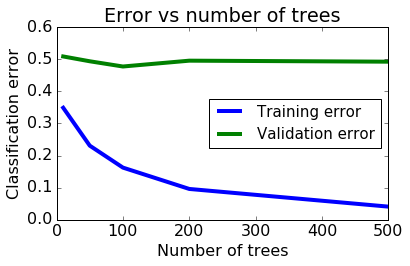

In [253]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')